##### Copyright (c) 2021 Spanish National Research Council

In [35]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#    http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or
# implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Machine Learning Models

The aim of this notebook is to forecast COVID-19 time series using ML models. These models are 
ARIMA, Random Forest, Gradient Boosting for regression, SVR, KRR, KNN, GLM.

Target variables are:
1. Daily positive cases
3. Hospital bed occupancy
4. ICU bed occupancy

The target variable used in this notebook will be `daily_cases`.

## Models

- [Baseline](#baseline)
- [GLM](#GLM)
- [Random Forest](#RF)
- [Support Vector Regression](#SVR)
- [Kernel Ridge Regression](#KRR)
- [KNN](#KNN)
- [Gradient Boosting Regressor](#GBR)
- [ARIMA](#ARIMA)

All models except the ARIMA model are not autoregressive, so it necessary to modify the target variable to create lagged observations in order to predict with these models at 7 future instants in time. These models will try to find dependent relationships between the features at time $t, t-1, ..., t-6$ to predict the target at time $t+7$. In contrast ARIMA model will try to use the dependent relationship between an observation and some number of lagged observations of the target variable (**univariate time series**).

## Setup

In [243]:
import os
from itertools import product
import pathlib
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import sqrt
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import time
from datetime import date, timedelta
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from tqdm import tqdm
import random
import warnings
warnings.filterwarnings("ignore")

In [244]:
sys.path.insert(0, str(pathlib.Path.cwd().parent / 'src'))
from utils import Paths

## COVID-19 dataset

This project uses a covid-19 data from Cantabria (Spain) obtained from:

1. [Cantabria Health Service](https://www.scsalud.es/coronavirus).
2. [Cantabria Institute of Statistics](https://www.icane.es/covid19/dashboard/home/home) (ICANE).
3. [Ministry of Health, Consumer Affairs and Social Welfare](https://www.mscbs.gob.es).

To generate and process regional COVID-19 data from scratch use:
```bash
python src/data.py
python src/data.py --files covid
```
The dataset to be used is located in ./data/processed/covid/region/all_data_cantb.csv. This dataset contains 19 different features: 
* `date`: Date of publication of the data. The time difference between consecutive entries is one day.
* `daily_cases`: Daily incidence in Cantabria.
* `daily_deaths`: Daily deaths due to coronavirus.
* `cumulative_cases`: Number of COVID-19 positive cases accumulated to date.
* `cumulative_deaths`: Number of COVID-19 deaths accumulated to date.
* `hospital_occ`: Number of hospital beds occupied by COVID-19 patients on that date.
* `icu_occ`: Number of ICU beds occupied by COVID-19 patients on that date.
* `new_hospital_cases`: Difference in the number of hospitalised coronavirus patients compared to the previous day.
* `new_icu_cases`: Difference in the number of patients in ICU due to coronavirus compared to the previous day.
* `daily_antibody_tests`: Daily antibody test.
* `daily_antigen_tests`: Daily antigen test.
* `daily_pcr_tests`: Daily PCR tests.
* `daily_total_tests`: Sum of daily antibody, antigen and PCR tests.
* `vaccinated_pp`: Number of persons vaccinated with the full schedule to date.
* `cases7`: 7-day cumulative incidence in Cantabria.
* `cases14`: Incidence accumulated for 14 days in Cantabria.
* `incidence7`: Accumulated incidence per 100,000 inhabitants for 7 days in Cantabria.
* `incidence14`: Accumulated incidence per 100,000 inhabitants per 14 days in Cantabria.
* `daily_positivity`: Daily positivity rate. The number of positive tests (`daily_cases`) divided by the number of total tests (`daily_total_tests`).

These were collected every day, beginning in 29 February 2020. Except for `vaccinated_pp`  which started to be collected on 04/02/2021 and the data is not updated on weekends.

### Paths

In [245]:
PATHS = Paths()
figures_path = PATHS.base / 'figures' / 'new_ml_models'
figures_path.exists() or os.makedirs(figures_path)
data_path = PATHS.processed / 'covid' / 'region' / 'all_data_cantb.csv'

### Load data

In [246]:
# Load data
df = pd.read_csv(data_path, sep=',').copy()
df = df.set_index('date')

In [247]:
df.tail(10)

,daily_cases,daily_deaths,cumulative_cases,cumulative_deaths,icu_occ,daily_antibody_tests,daily_antigen_tests,daily_pcr_tests,vaccinated_pp,hospital_occ,daily_total_tests,cases7,cases14,incidence7,incidence14,new_hospital_cases,new_icu_cases,daily_positivity
date,,,,,,,,,,,,,,,,,,
2021/09/06,58,0,46281,607,5,88,172,947,415692,43,1207,505,1234,87,213,0,0,0.048053
2021/09/07,60,0,46341,607,5,23,278,1094,418094,41,1395,486,1179,84,203,0,0,0.043011
2021/09/08,57,0,46398,607,5,52,138,921,420801,39,1111,469,1106,81,191,0,0,0.051305
2021/09/09,64,1,46462,608,6,17,123,985,423588,36,1125,449,1078,78,186,0,1,0.056889
2021/09/10,58,0,46520,608,7,54,130,853,428020,35,1037,433,994,75,172,0,1,0.055931
2021/09/11,35,0,46555,608,7,0,89,798,0,40,887,385,943,67,163,5,0,0.039459
2021/09/12,37,0,46592,608,8,0,102,511,0,40,613,369,881,64,152,0,1,0.060359
2021/09/13,44,0,46636,608,7,11,178,909,431948,34,1098,355,860,62,149,0,0,0.040073
2021/09/14,54,0,46690,608,6,73,118,1040,431948,32,1231,349,835,61,144,0,0,0.043867


### Target variables

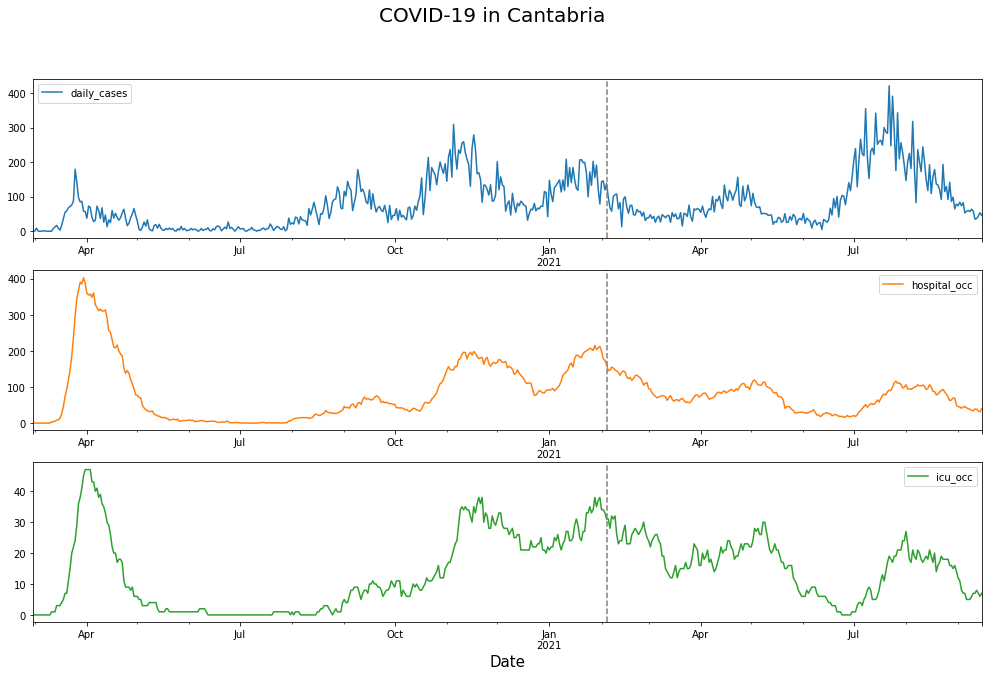

In [248]:
mpl.rcParams['axes.grid'] = False
fig, axs = plt.subplots(figsize=(17, 10))
plot_cols = ['daily_cases', 'hospital_occ', 'icu_occ']
plot_features = df[plot_cols]
plot_features.index = pd.to_datetime(df.index)
axes = plot_features.plot(subplots=True,
                          ax=axs,
                          title='COVID-19 in Cantabria',
                          legend='best')
for i,ax in enumerate(axes):
    ax.axvline(x=pd.to_datetime('2021/02/04'), linestyle='--', color='grey') # vaccination starts

fig.suptitle('COVID-19 in Cantabria', fontsize=20)
plt.xlabel('Date', fontsize=15)

# Save
fig_path = figures_path / 'target_variables.svg'
fig.savefig(fig_path)

## Inspect
Next, look at the statistics of the dataset. All variables must be positive.

In [249]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
daily_cases,565.0,82.853097,74.147122,0.0,29.00000,63.000000,118.000000,422.0
daily_deaths,565.0,1.079646,1.916435,0.0,0.00000,0.000000,1.000000,16.0
cumulative_cases,565.0,17872.971681,14250.221750,1.0,3172.00000,17364.000000,29688.000000,46736.0
cumulative_deaths,565.0,363.081416,183.595339,0.0,212.00000,342.000000,561.000000,608.0
icu_occ,565.0,14.212389,11.654795,0.0,3.00000,13.000000,23.000000,47.0
daily_antibody_tests,565.0,79.867257,158.562587,0.0,0.00000,32.000000,81.000000,1284.0
daily_antigen_tests,565.0,46.412389,53.844123,0.0,0.00000,38.000000,79.000000,278.0
daily_pcr_tests,565.0,1237.088496,621.029795,0.0,763.00000,1256.000000,1675.000000,3307.0
vaccinated_pp,565.0,47573.019469,107218.404285,0.0,0.00000,0.000000,20018.000000,441770.0
hospital_occ,565.0,84.274336,76.588618,1.0,27.00000,70.000000,114.000000,403.0


## Correlation matrix
A correlation matrix is a tabular data that represents the correlations between pairs of variables. 
Each cell of the correlation matrix is a correlation coefficient between the two variables corresponding to the row and column of the cell. 

A correlation coefficient is a number that denotes the strength of the relationship between two variables.
There are several types of correlation coefficients, but the most common of them all is Pearson's coefficient.

Text(113.09375, 0.5, 'Epidemiological features')

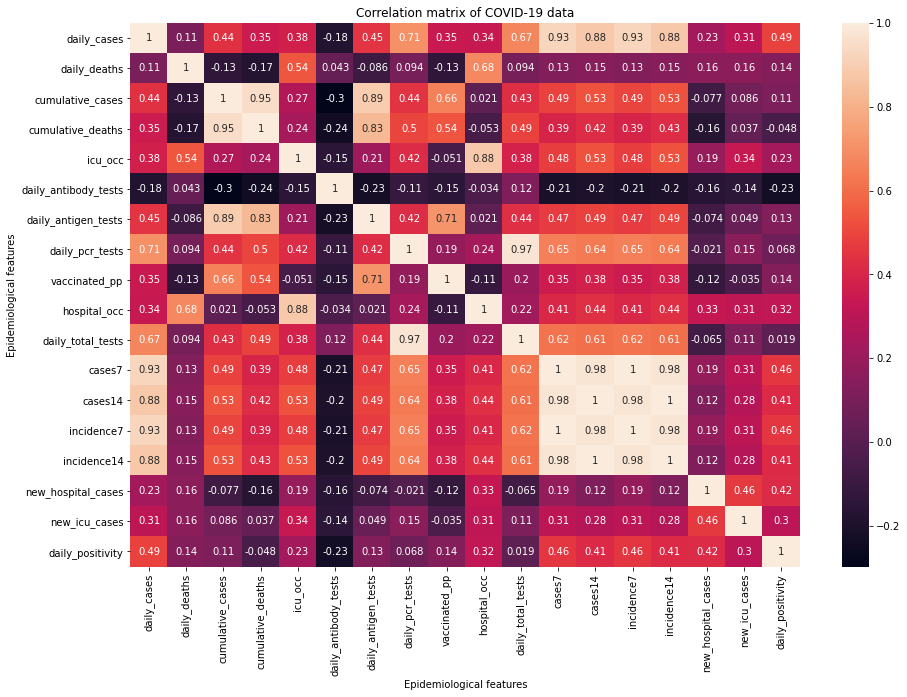

In [250]:
correlation_matrix = df.corr()

mpl.rcParams['figure.figsize'] = (15, 10)
sns.heatmap(correlation_matrix, annot = True)
plt.title("Correlation matrix of COVID-19 data")
plt.xlabel("Epidemiological features")
plt.ylabel("Epidemiological features")

## Class and methods
I will use a `(80%, 15%, 5%)` split for the training, validation, and test sets. The data is **not** being randomly shuffled before splitting because:

1. It ensures that chopping the data into windows of consecutive samples is still possible.
2. It ensures that the validation/test results are more realistic, being evaluated on the data collected after the model was trained.

An important step when training an ML and DL model is the scaling of the features, as it helps in the learning process. There are different ways of scaling data: normalization and standardization.

In [251]:
class ForecastingML:
    """
    Class to:
    1. Create lags.
    2. Split dataset in train, val, test.
    3. Fit model.
    4. Make predictions.
    5. Plot predictions.
    """
    
    def __init__(self, df: pd.DataFrame, target,
                 time_step=7, past_step=7):
        """
        Init variables.
        Args:
            df (DataFrame): Features and target variable.
            target: Target variable to forecast.
        """
        self.df = df
        self.target = target
        self.time_step = time_step
        self.past_step = past_step
    
    def matrix_corr(self):
        correlation_matrix = self.df.corr()
        mpl.rcParams['figure.figsize'] = (15, 10)
        ax = sns.heatmap(correlation_matrix, annot = True)
        plt.title("Correlation matrix of COVID-19 data", fontsize=16)
        plt.xlabel("Epidemiological features", fontsize=16)
        plt.ylabel("Epidemiological features", fontsize=16)
        # Save
        fig_path = figures_path / 'correlation_matrix.svg'
        fig = ax.get_figure()
        fig.savefig(fig_path, bbox_inches="tight")
        # plt.close()
        
    def make_lags(self):
        """
        Make lags from target variable.
        Details:
            t0 = Start date (29/02/2020) = t - past_step
            t = t0 + past_step. New start date after making lags.
            t_future = past_step + time_step = t + time_step. Predicted moment.
        Args:
            time_step: Future moments.
            past_step: Number of lags or past moments.
        Returns:
            X: Features at time 't' and lags at (t0, ..., t)
            y: Target at time 't_future'.
        """
        
        # Data
        data = self.df.copy()
        data.index = pd.to_datetime(data.index)        
#         data = data.reset_index()
        target = self.target

        # Features: t = t0 + past_step
        X = data[self.past_step:-self.time_step].drop(columns=[target])

        # Delays: t, t-1, ..., t-past_step=t0
        for i in range(self.past_step):
            first_value = i
            last_value = self.time_step + self.past_step - i
            
            delay = data[target].iloc[first_value:-last_value].values
            X["delay{}_{}".format(self.past_step - i, target)] = delay

        # Target: t + time_step
        y = data[target].iloc[int(self.past_step + self.time_step):]
        
        self.X = X
        self.y = y
    
    def make_splits(self, pct_train=85, pct_val=10, pct_test=5):
        """
        Split the dataframe in train, validation and test dataframe.
        For ML models not autoregressive, it is necessary to create lags from target variable. 
        Args:
            pct_train: Percentage of data to train
            pct_val: Percentage of data to validate
            pct_test: Percentage of data to test
        """
        
        self.make_lags()
        X = self.X
        y = self.y
        
        n = len(X) 
        
        X_train = X.iloc[:int(n*pct_train/100)]
        y_train = y.iloc[:int(n*pct_train/100)]
        X_val = X.iloc[int(n*pct_train/100):-int(n*pct_test/100)]
        y_val = y.iloc[int(n*pct_train/100):-int(n*pct_test/100)]   
        X_test = X.iloc[-int(n*pct_test/100):]  
        y_test = y.iloc[-int(n*pct_test/100):]  
        
        split_df = {'train': {}, 'val': {}, 'test': {}}
        split_df['train']['X'] = X_train
        split_df['train']['y'] = y_train
        split_df['val']['X'] = X_val
        split_df['val']['y'] = y_val
        split_df['test']['X'] = X_test
        split_df['test']['y'] = y_test
        
        self.split_df = split_df
        
    def normalize(self, graph=False):
        """
        Normalize data using train dataset so the trained models will have no access 
        to the values in the validation and test sets.
        """
        X_train = self.split_df['train']['X']
        Xmin = X_train.min()
        Xmax = X_train.max()

        norm_df = {'train': {}, 'val': {}, 'test': {}}

        for i in ['train', 'val', 'test']:
            norm_df[i]['X'] = (self.split_df[i]['X'] - Xmin) / (Xmax - Xmin)
        
        self.scale_df = norm_df
        
        if graph:
            features = self.scale_df['train']['X'].iloc[:, :-self.past_step]
            distro = features.melt(var_name='Column', value_name='Normalized')
            plt.figure(figsize=(15, 3))
            plt.title('Distribution of features')
            
            ax = sns.violinplot(x='Column', y='Normalized', data=distro)
            _ = ax.set_xticklabels(features.keys(), rotation=90)
            # Save
            fig_path = figures_path / 'distribution_features.svg'
            fig = ax.get_figure()
            fig.savefig(fig_path, bbox_inches="tight")
            # plt.close()

    def standardize(self, graph=False):
        """
        Standardize data using train dataset so the trained models will have no access 
        to the values in the validation and test sets.
        """
        X_train = self.split_df['train']['X']
        mean =  X_train.mean()
        sd =  X_train.std()
        std_df = {'train': {}, 'val': {}, 'test': {}}
        
        for i in ['train', 'val', 'test']:
            std_df[i]['X'] = (self.split_df[i]['X'] - mean) / sd
            
            
        self.scale_df = std_df   

        if graph:
            features = self.scale_df['train']['X'].iloc[:, :-self.past_step]
            distro = features.melt(var_name='Column', value_name='Standardized')
            plt.figure(figsize=(15, 3))
            plt.title('Distribution of features')
            
            ax = sns.violinplot(x='Column', y='Standardized', data=distro)
            _ = ax.set_xticklabels(features.keys(), rotation=90)
            # Save
            fig_path = figures_path / 'distribution_features.svg'
            fig = ax.get_figure()
            fig.savefig(fig_path, bbox_inches="tight")
            # plt.close()
        
    def model_summary(self, model):
        """
        Calculate predictions and evaluate the errors with some metrics:
        Mean Absolute Error (MAE), Mean Absolute Percentage Error (MAPE), Mean Square Error (MSE),
        Root Mean Square Error (RMSE).

        Args:
            model: Trained model used to predict.

        Return: Dictionary with the metrics of each dataframe (train, val, test).
        """
        self.models_metrics = {}
        splits = self.split_df
        metrics = {'rmse': {}, 'mse': {}, 'mae': {}, 'mape': {}}

        for i in ['train', 'val', 'test']:
            x_t = self.scale_df[i]['X']
            y_t = splits[i]['y']

            try:
                if len(x_t) != 0:
                    y_p = model.predict(x_t) 
                    
                    # Metrics
                    mse = mean_squared_error(y_true=y_t,
                                             y_pred=y_p,
                                             squared=False)
                    rmse = sqrt(mse)
                    mae = mean_absolute_error(y_true=y_t,
                                              y_pred=y_p)
                    mape = mean_absolute_percentage_error(y_true=y_t,
                                                          y_pred=y_p)
                    metrics['mse'][i] = mse
                    metrics['rmse'][i] = rmse
                    metrics['mae'][i] = mae
                    metrics['mape'][i] = mape

                    df_metrics = pd.DataFrame.from_dict(metrics, orient='index')
                    self.models_metrics[model.name] = df_metrics

            except Exception as e:
                print(e)

        return df_metrics

    def model_plot(self, model):
        """
        Plot forecast.

        Args:
            model: Trained model used to predict.

        Return: Plot train, val and test.
        """

        splits_orig = self.split_df
        splits_scale = self.scale_df
        X = self.X
        y = self.y
        t = X.index
        t_forecast = y.index
        forecast = pd.DataFrame()
        
        # Figure
        fig, axs = plt.subplots(4)
        fig.suptitle(model.name)
        
        for index, i in enumerate(['train', 'val', 'test']):
            x_scaled = splits_scale[i]['X']
            y_orig = splits_orig[i]['y']
            start_day = y_orig.index[0]
            end_day = y_orig.index[-1]

            try:
                if len(x_scaled) != 0:
                    y_p = model.predict(x_scaled) 
                    y_p = pd.DataFrame(y_p)
                    y_p.index = y_orig.index
                    forecast = pd.concat([forecast, y_p])

                    # Plots
                    plt.rcParams['figure.figsize'] = (14, 15)
#                     axs[index].set_xlim(start_day, end_day)
                    axs[index].plot(y_orig, color='blue')
                    axs[index].plot(y_p, color='red')
                    axs[index].set_xlabel('Time, t [days]', fontsize=13)
                    axs[index].set_ylabel(y_orig.name,  fontsize=13)
                    axs[index].legend([f'{i.upper()} Dataset', 'Forecast'], loc='best')

            except Exception as e:
                print(e)
        
        axs[3].set_xlim(X.index[0], y.index[-1])
                
        axs[3].plot(y, color='blue')
        axs[3].plot(forecast, color='red')
        axs[3].set_xlabel('Time, t [days]', fontsize=13)
        axs[3].set_ylabel(y_orig.name,  fontsize=13)
        axs[3].legend(['Data', 'Forecast'], loc='best')
        plt.subplots_adjust(hspace=0.4)
        fig.suptitle(model.name, fontsize=16)
        # Vertical lines
        axs[3].axvline(x=pd.to_datetime('2021/02/04'), linestyle='--', color='grey') # vaccination starts
        for i in ['val', 'test']:
            y_orig = splits_orig[i]['y']
            start_day = y_orig.index[0]
            axs[3].axvline(x=start_day, linestyle='-', color='black') # val y test dataset starts
        
        # Save
        fig_path = figures_path / f'{model.name}_{self.target}.svg'
        fig.savefig(fig_path)

#         plt.show()

In [252]:
metrics = {'daily_cases': {}, 'icu_occ': {}, 'hospital_occ': {}}
random.seed(0)

In [253]:
target = ForecastingML(df, 'daily_cases')
target.make_splits()
target.normalize()
target.X.head()

,daily_deaths,cumulative_cases,cumulative_deaths,icu_occ,daily_antibody_tests,daily_antigen_tests,daily_pcr_tests,vaccinated_pp,hospital_occ,daily_total_tests,...,new_hospital_cases,new_icu_cases,daily_positivity,delay7_daily_cases,delay6_daily_cases,delay5_daily_cases,delay4_daily_cases,delay3_daily_cases,delay2_daily_cases,delay1_daily_cases
date,,,,,,,,,,,,,,,,,,,,,
2020-03-07,0,12,0,0,0,0,5,0,1,5,...,0,0,0.2,1,0,9,0,0,0,1
2020-03-08,0,12,0,0,0,0,5,0,1,5,...,0,0,0.0,0,9,0,0,0,1,1
2020-03-09,0,12,0,0,0,0,7,0,1,7,...,0,0,0.0,9,0,0,0,1,1,0
2020-03-10,0,12,0,0,0,0,15,0,1,15,...,0,0,0.0,0,0,0,1,1,0,0
2020-03-11,0,12,0,1,0,0,34,0,4,34,...,3,1,0.0,0,0,1,1,0,0,0


In [254]:
df.head(20)

,daily_cases,daily_deaths,cumulative_cases,cumulative_deaths,icu_occ,daily_antibody_tests,daily_antigen_tests,daily_pcr_tests,vaccinated_pp,hospital_occ,daily_total_tests,cases7,cases14,incidence7,incidence14,new_hospital_cases,new_icu_cases,daily_positivity
date,,,,,,,,,,,,,,,,,,
2020/02/29,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.000000
2020/03/01,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.000000
2020/03/02,9,0,10,0,0,0,0,10,0,1,10,0,0,0,0,0,0,0.900000
2020/03/03,0,0,10,0,0,0,0,24,0,1,24,0,0,0,0,0,0,0.000000
2020/03/04,0,0,10,0,0,0,0,24,0,1,24,0,0,0,0,0,0,0.000000
2020/03/05,0,0,10,0,0,0,0,4,0,1,4,0,0,0,0,0,0,0.000000
2020/03/06,1,0,11,0,0,0,0,4,0,1,4,0,0,0,0,0,0,0.250000
2020/03/07,1,0,12,0,0,0,0,5,0,1,5,11,0,2,0,0,0,0.200000
2020/03/08,0,0,12,0,0,0,0,5,0,1,5,11,0,2,0,0,0,0.000000


## Baseline<a name="baseline"></a>

Fundamentally, a baseline is a model that is both simple to set up and has a reasonable chance of providing decent results.

In this case, the model will learn to predict 7 future days given the same number of past days.

In [255]:
class repeat_baseline():
    """
    The model will learn to predict n future days given the same number of past days.
    """
    def __init__(self, ForecastingML):
        self.name = 'baseline'
        self.time_step = ForecastingML.time_step
        self.split_df = ForecastingML.split_df
        self.X = ForecastingML.X
        self.y = ForecastingML.y
        self.target = ForecastingML.target
        
    def predict(self, y):
        y_p = y.shift(self.time_step, fill_value=0)
        return y_p
    
    def summary(self):
        
        metrics = {'rmse': {}, 'mse': {}, 'mae': {}, 'mape': {}}
        for i in ['train', 'val', 'test']:
            y_t = self.split_df[i]['y']

            try:
                if len(y_t) != 0:
                    y_p = baseline.predict(y_t) 
                    
                    # Metrics
                    mse = mean_squared_error(y_true=y_t,
                                             y_pred=y_p,
                                             squared=False)
                    rmse = sqrt(mse)
                    mae = mean_absolute_error(y_true=y_t,
                                              y_pred=y_p)
                    mape = mean_absolute_percentage_error(y_true=y_t,
                                                          y_pred=y_p)
                    metrics['mse'][i] = mse
                    metrics['rmse'][i] = rmse
                    metrics['mae'][i] = mae
                    metrics['mape'][i] = mape
                    
                    df_metrics = pd.DataFrame.from_dict(metrics, orient='index')

            except Exception as e:
                print(e)

        return df_metrics
    
    def plot(self):
        """
        Plot forecast.

        Args:
            model: Trained model used to predict.

        Return: Plot train, val and test.
        """

        y = self.y
        X = self.X
        forecast = pd.DataFrame()
        
        # Figure
        fig, axs = plt.subplots(4)
        fig.suptitle(self.name)
        
        for index, i in enumerate(['train', 'val', 'test']):
            y_orig = self.split_df[i]['y']

            try:
                if len(y_orig) != 0:
                    y_p = self.predict(y_orig) 
#                     forecast = pd.concat([forecast, y_p])

                    # Plots
                    plt.rcParams['figure.figsize'] = (14, 15)
                    axs[index].plot(y_orig, color='blue')
                    axs[index].plot(y_p.iloc[self.time_step:], color='red')
                    axs[index].set_xlabel('Time, t [days]', fontsize=13)
                    axs[index].set_ylabel(y_orig.name,  fontsize=13)
                    axs[index].legend([f'{i.upper()} Dataset', 'Forecast'], loc='best')

            except Exception as e:
                print(e)
        
        forecast = self.predict(y) 
        axs[3].set_xlim(X.index[0], y.index[-1])
                
        axs[3].plot(y, color='blue')
        axs[3].plot(forecast.iloc[self.time_step:], color='red')
        axs[3].set_xlabel('Time, t [days]', fontsize=13)
        axs[3].set_ylabel(y_orig.name,  fontsize=13)
        axs[3].legend(['Data', 'Forecast'], loc='best')
        plt.subplots_adjust(hspace=0.4)
        fig.suptitle(self.name, fontsize=16)
        # Vertical lines
        axs[3].axvline(x=pd.to_datetime('2021/02/04'), linestyle='--', color='grey') # vaccination starts
        for i in ['val', 'test']:
            y_orig = self.split_df[i]['y']
            start_day = y_orig.index[0]
            axs[3].axvline(x=start_day, linestyle='-', color='black') # val y test dataset starts
        
        # Save
        fig_path = figures_path / f'{self.name}_{self.target}.svg'
        fig.savefig(fig_path)

            

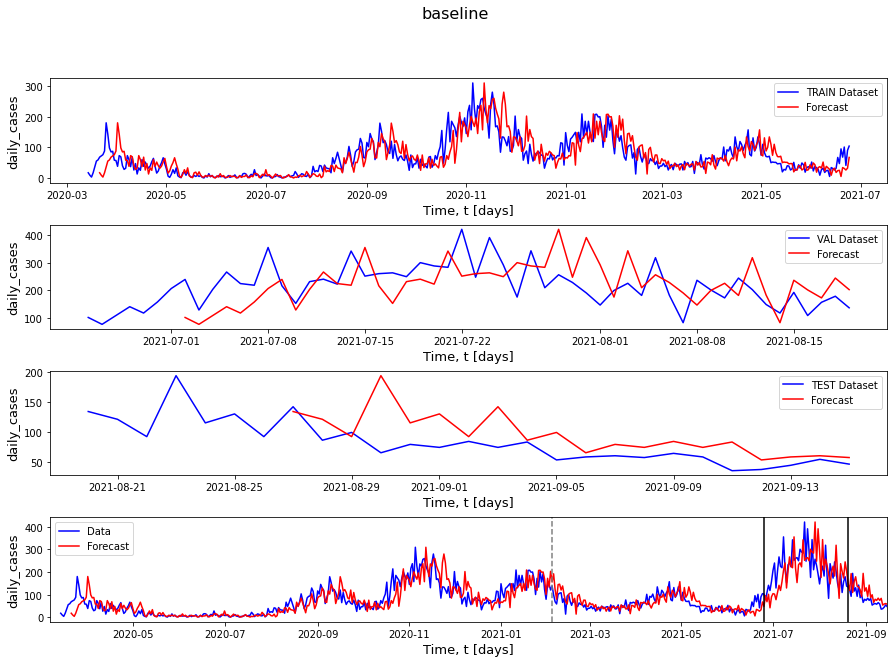

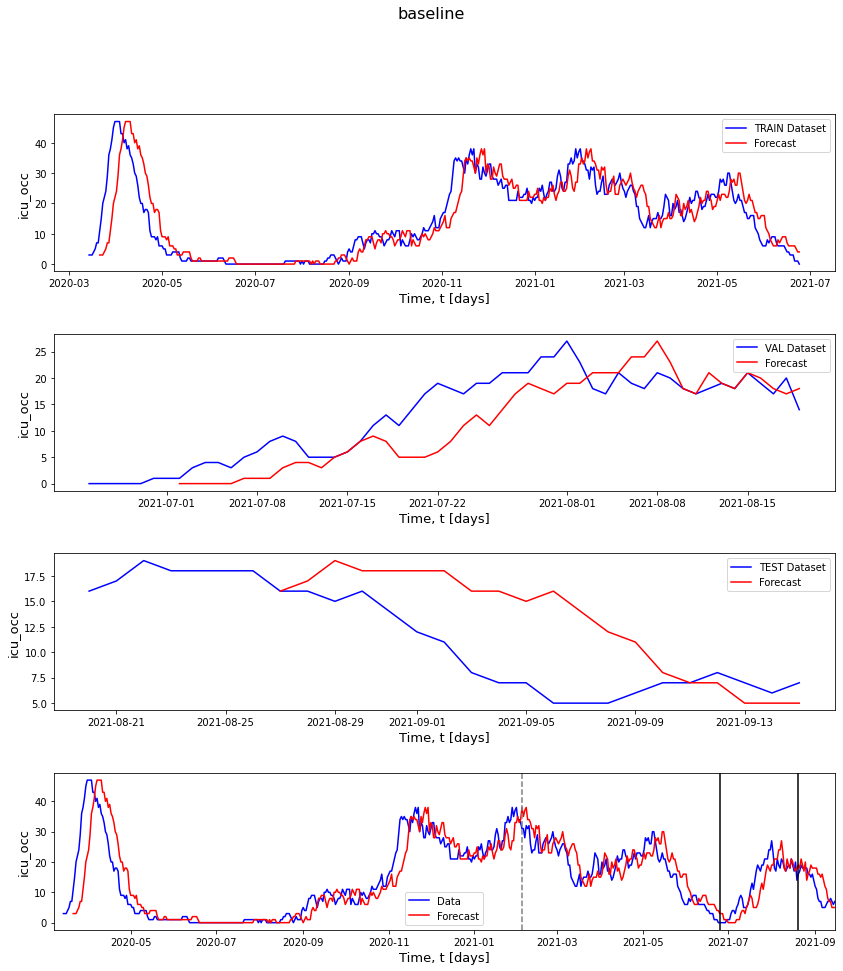

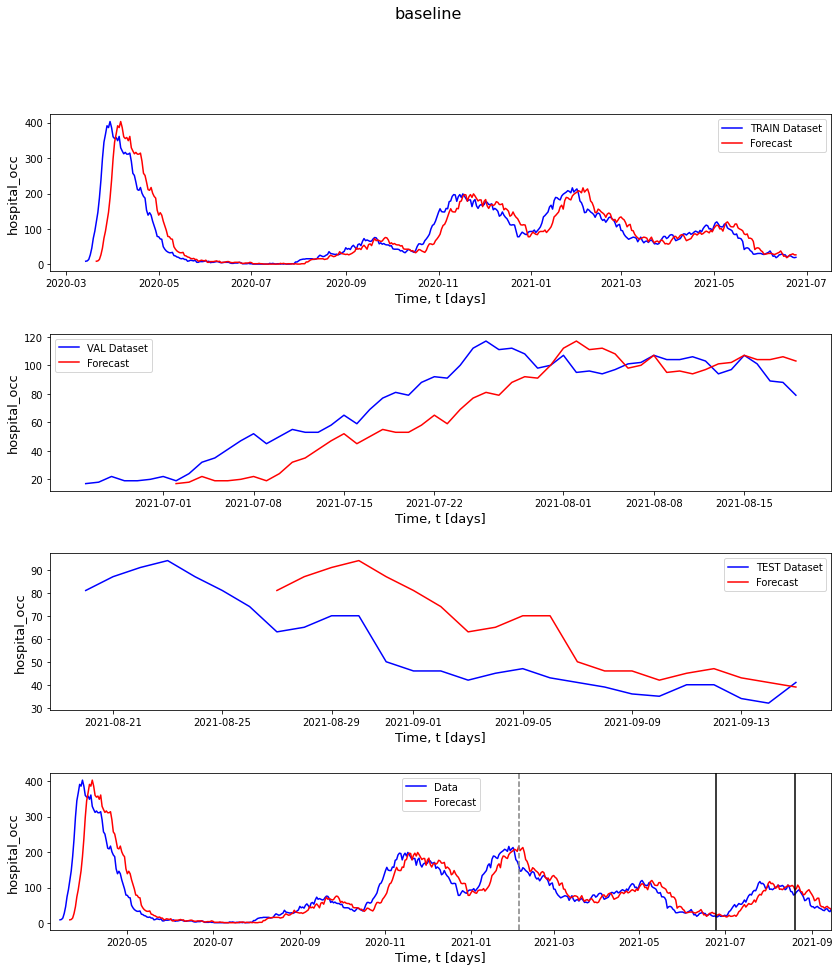

In [256]:
# Data
for t in ['daily_cases', 'icu_occ', 'hospital_occ']:
    # Data
    target = ForecastingML(df, t)
    target.make_splits()
    target.normalize()
    
    # Metrics
    metrics[f'{t}']['baseline'] = repeat_baseline(target).summary()
    
    # PLot
    repeat_baseline(target).plot()

## GLM<a name="GLM"></a>

Generalized Linear Models currently supports estimations using the one-parameter exponential families.

### Example

In [257]:
# Data
daily = ForecastingML(df, 'daily_cases')
daily.make_splits()
daily.normalize()
X_train = daily.scale_df['train']['X'].values
y_train = daily.split_df['train']['y'].values

In [258]:
# Search parameters
param_grid = [sm.families.Gaussian(), 
              sm.families.Gamma(), 
              sm.families.Binomial(), 
              sm.families.Poisson(),
              sm.families.InverseGaussian()]
aux = np.inf
for fam in param_grid:
    try:
        t0 = time.time()
        glm_model = sm.GLM(y_train, X_train, family=fam)
        glm_model = glm_model.fit()
        glm_model.name = 'GLM'
        t = time.time()
        glm_metrics = daily.model_summary(glm_model)
#         print('Family:', fam)
#         print(glm_metrics)
        v = glm_metrics.loc['mse', 'val']
        if v <= aux:
            t0_b = t0
            t_b = t
            name = fam
            aux = v
            best = glm_metrics
    except:
        pass
    
print('Best exponential family:', name)
print(glm_metrics)
print('Elapsed time: ', t_b - t0_b, '(s)')

Best exponential family: <statsmodels.genmod.families.family.Gaussian object at 0x000001C7B2B51630>
             train         val       test
rmse  6.609622e+00   11.188787   8.330620
mse   4.368711e+01  125.188949  69.399233
mae   3.038985e+01   93.732705  63.004645
mape  7.344939e+14    0.466746   0.767960
Elapsed time:  0.011969566345214844 (s)


In [259]:
glm_model = sm.GLM(y_train, X_train, family=sm.families.Gaussian())
t0 = time.time()
glm_model = glm_model.fit()
print('Elapsed time: ', time.time() - t0, '(s)')
glm_model.name = 'GLM'

Elapsed time:  0.00994110107421875 (s)


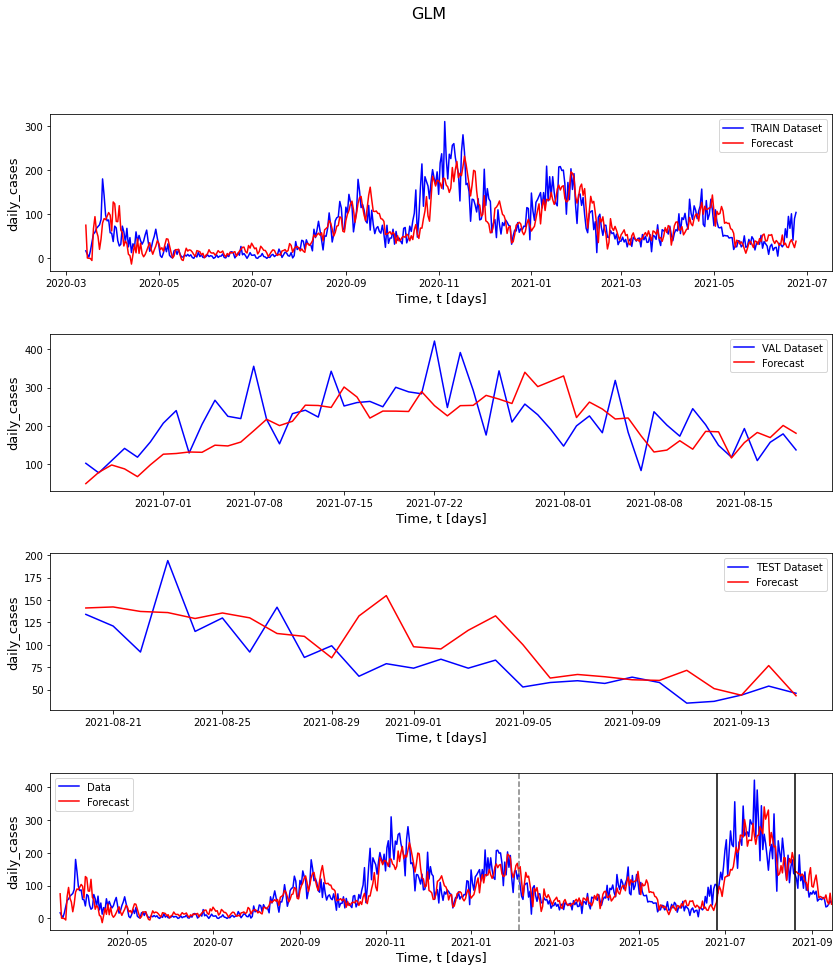

In [260]:
daily.model_plot(glm_model)

### Target variables

daily_cases. Elapsed time:  0.006639242172241211 (s)
icu_occ. Elapsed time:  0.00800323486328125 (s)
hospital_occ. Elapsed time:  0.0 (s)


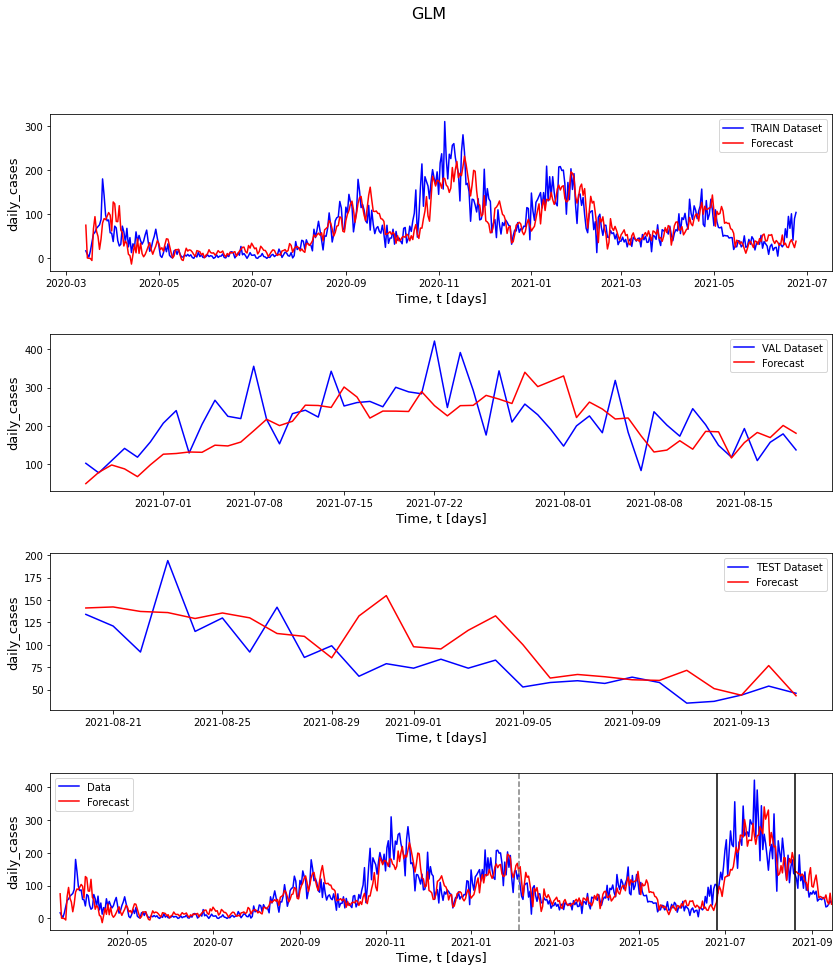

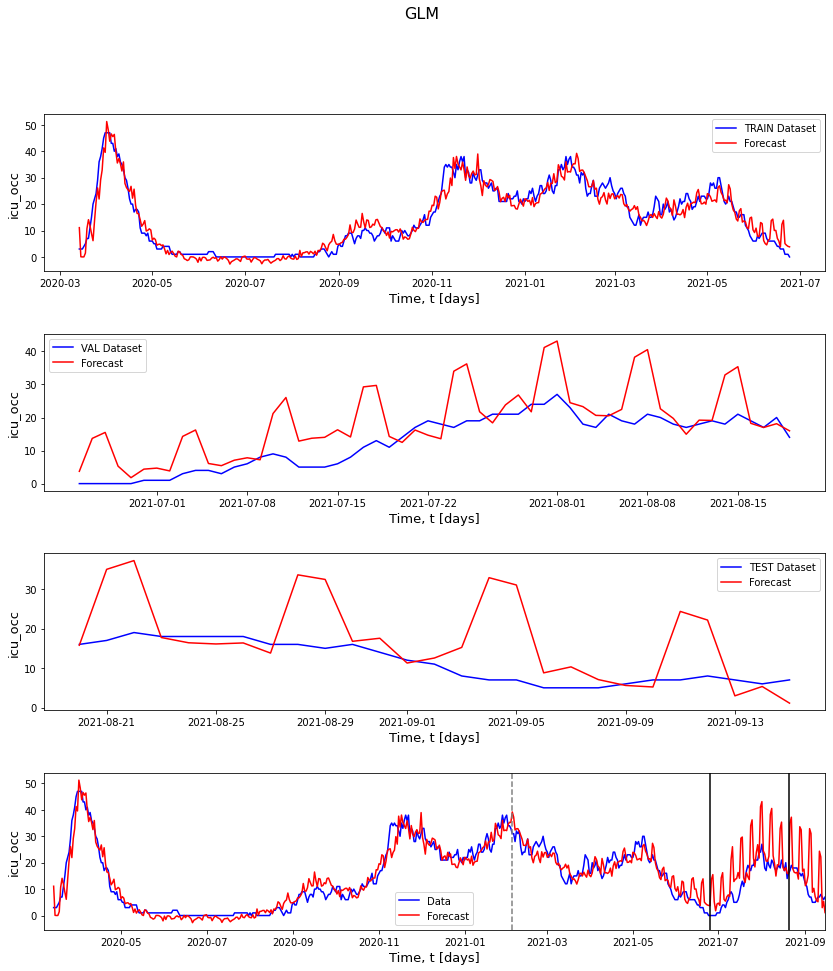

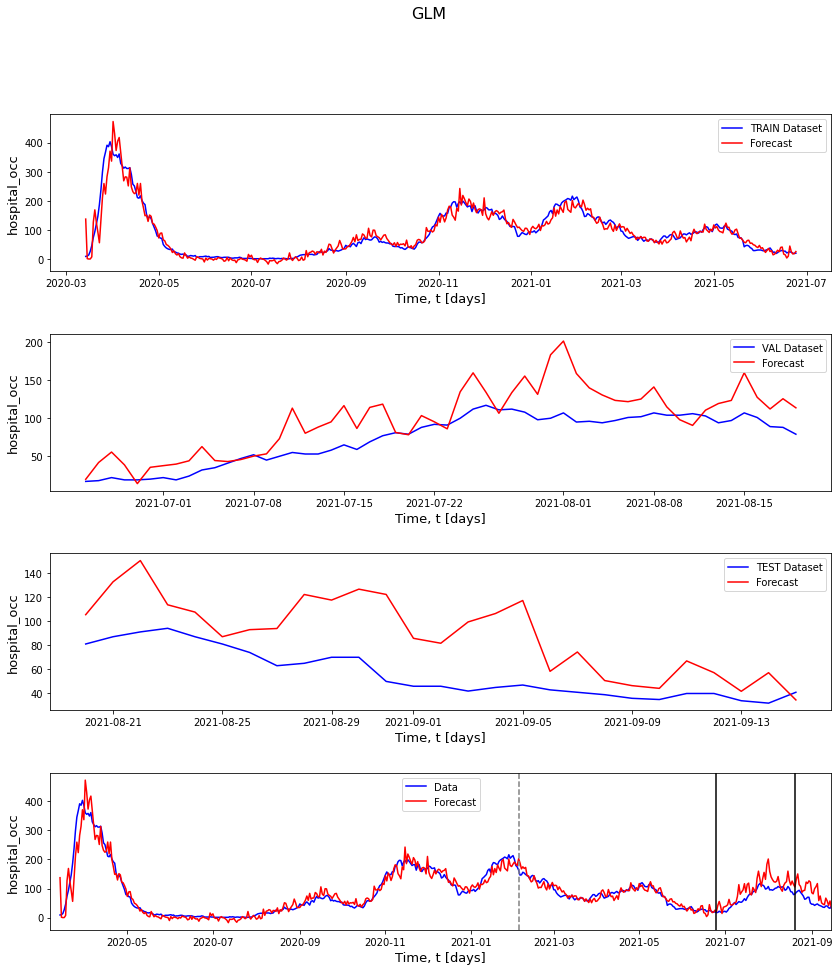

In [261]:
for target in ['daily_cases', 'icu_occ', 'hospital_occ']:
    # Data
    daily = ForecastingML(df, target)
    daily.make_splits()
    daily.normalize()
    X_train = daily.scale_df['train']['X'].values
    y_train = daily.split_df['train']['y'].values
    
    # Model
    glm_model = sm.GLM(y_train, X_train, family=sm.families.Gaussian())
    t0 = time.time()
    glm_model = glm_model.fit()
    print(f'{target}. Elapsed time: ', time.time() - t0, '(s)')
    glm_model.name = 'GLM'
    
    # Metrics
    metrics[f'{target}']['GLM'] = daily.model_summary(glm_model)
    
    # PLot
    daily.model_plot(glm_model)
    

## Random Forest<a name="RF"></a>

A random forest is a meta estimator that fits a number of classifying decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

### Daily cases

In [262]:
# Data
daily = ForecastingML(df, 'daily_cases')
daily.make_splits()
daily.normalize()
# X
X_train = daily.scale_df['train']['X']
X_val = daily.scale_df['val']['X']
X = pd.concat([X_train, X_val]).values
# y
y_train = daily.split_df['train']['y']
y_val = daily.split_df['val']['y']
y = pd.concat([y_train, y_val]).values

custom_cv = TimeSeriesSplit(max_train_size=None, n_splits=5)
param_grid = {
    'bootstrap': [False],
    'max_depth': [5, 10, 20, 30, 40],
    'max_features': [1, 2, 3, 4],
    'min_samples_leaf': [3, 4, 5, 7, 10],
    'min_samples_split': [2, 4, 6, 8, 10],
    'n_estimators': [1, 5, 10, 50]}

rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, 
                           param_grid = param_grid, 
                           n_jobs = -1, 
                           cv = custom_cv,
                           verbose = 2)

In [159]:
# Search best model
t0 = time.time()
models = grid_search.fit(X, y)
print('Elapsed time: ', time.time() - t0, '(s)')

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
Elapsed time:  67.69483494758606 (s)


In [160]:
# Best parameters for our model
best_grid = models.best_params_
best_grid

{'bootstrap': False,
 'max_depth': 20,
 'max_features': 2,
 'min_samples_leaf': 5,
 'min_samples_split': 6,
 'n_estimators': 5}

In [263]:
# Fit best model
t0 = time.time()
rf_model = RandomForestRegressor(bootstrap=False,
                                 max_depth=10,
                                 max_features=2,
                                 min_samples_leaf=4, 
                                 min_samples_split=8, 
                                 n_estimators=5,
                                 criterion='mse')
rf_model = rf_model.fit(X_train, y_train)
rf_model.name = 'Random_Forest'
print('Elapsed time: ', time.time() - t0, '(s)')
daily.model_summary(rf_model)

Elapsed time:  0.019634485244750977 (s)


,train,val,test
rmse,4.169881e+00,10.138960,5.606021
mse,1.738791e+01,102.798512,31.427475
mae,1.234812e+01,82.689990,24.228836
mape,4.124175e+14,0.348366,0.347168


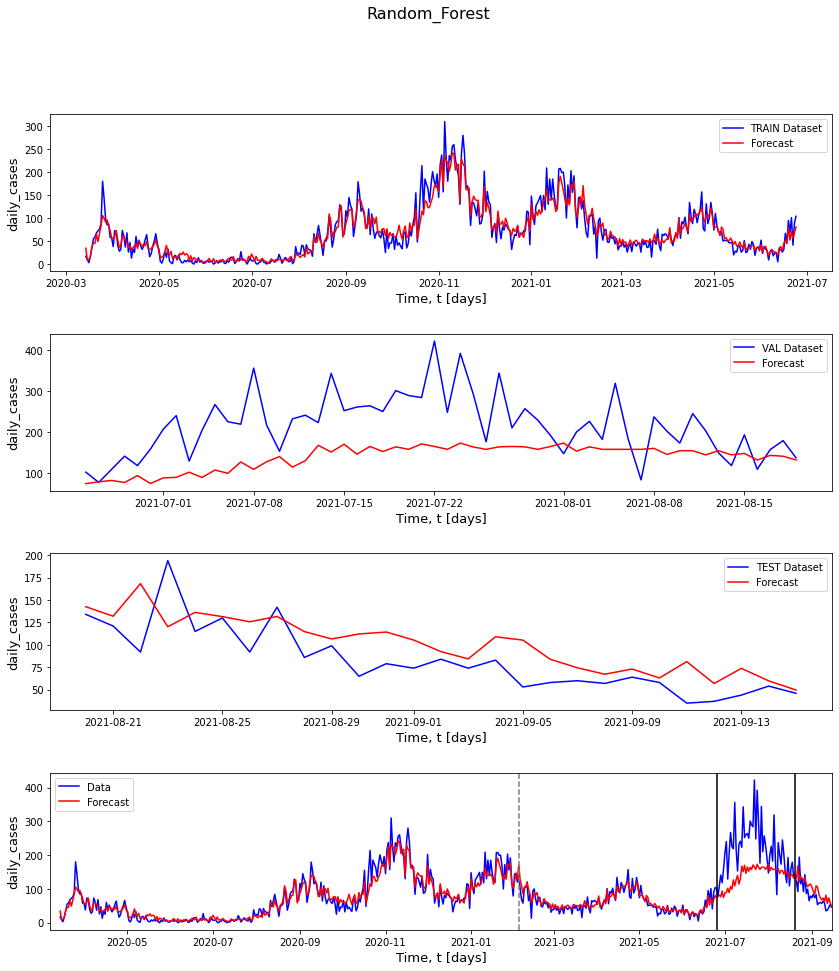

In [264]:
# Metrics
metrics['daily_cases']['Random_Forest'] = daily.model_summary(rf_model)
# Plot
daily.model_plot(rf_model)

### ICU occupancy

In [265]:
# Data
icu = ForecastingML(df, 'icu_occ')
icu.make_splits()
icu.normalize()
# X
X_train = icu.scale_df['train']['X']
X_val = icu.scale_df['val']['X']
X = pd.concat([X_train, X_val]).values
# y
y_train = icu.split_df['train']['y']
y_val = icu.split_df['val']['y']
y = pd.concat([y_train, y_val]).values

custom_cv = TimeSeriesSplit(max_train_size=None, n_splits=5)
param_grid = {
    'bootstrap': [False],
    'max_depth': [5, 10, 20, 30, 40],
    'max_features': [1, 2, 3, 4],
    'min_samples_leaf': [3, 4, 5, 7, 10],
    'min_samples_split': [2, 4, 6, 8, 10],
    'n_estimators': [1, 5, 10, 50]}

rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, 
                           param_grid = param_grid, 
                           n_jobs = -1, 
                           cv = custom_cv,
                           verbose = 2)

In [164]:
# Search best model
t0 = time.time()
models = grid_search.fit(X, y)
print('Elapsed time: ', time.time() - t0, '(s)')

# Best parameters for our model
best_grid = models.best_params_
best_grid

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
Elapsed time:  93.92105269432068 (s)


{'bootstrap': False,
 'max_depth': 5,
 'max_features': 1,
 'min_samples_leaf': 4,
 'min_samples_split': 8,
 'n_estimators': 10}

In [266]:
# Fit best model
t0 = time.time()
rf_model = RandomForestRegressor(bootstrap=False,
                                 max_depth=40,
                                 max_features=4,
                                 min_samples_leaf=7, 
                                 min_samples_split=8, 
                                 n_estimators=5,
                                 criterion='mse')
rf_model = rf_model.fit(X_train, y_train)
rf_model.name = 'Random_Forest'
print('Elapsed time: ', time.time() - t0, '(s)')
icu.model_summary(rf_model)

Elapsed time:  0.022837162017822266 (s)


,train,val,test
rmse,1.544751e+00,2.688363e+00,3.270912
mse,2.386256e+00,7.227297e+00,10.698865
mae,1.541493e+00,5.987453e+00,10.193517
mape,1.726132e+14,2.315593e+15,1.116428


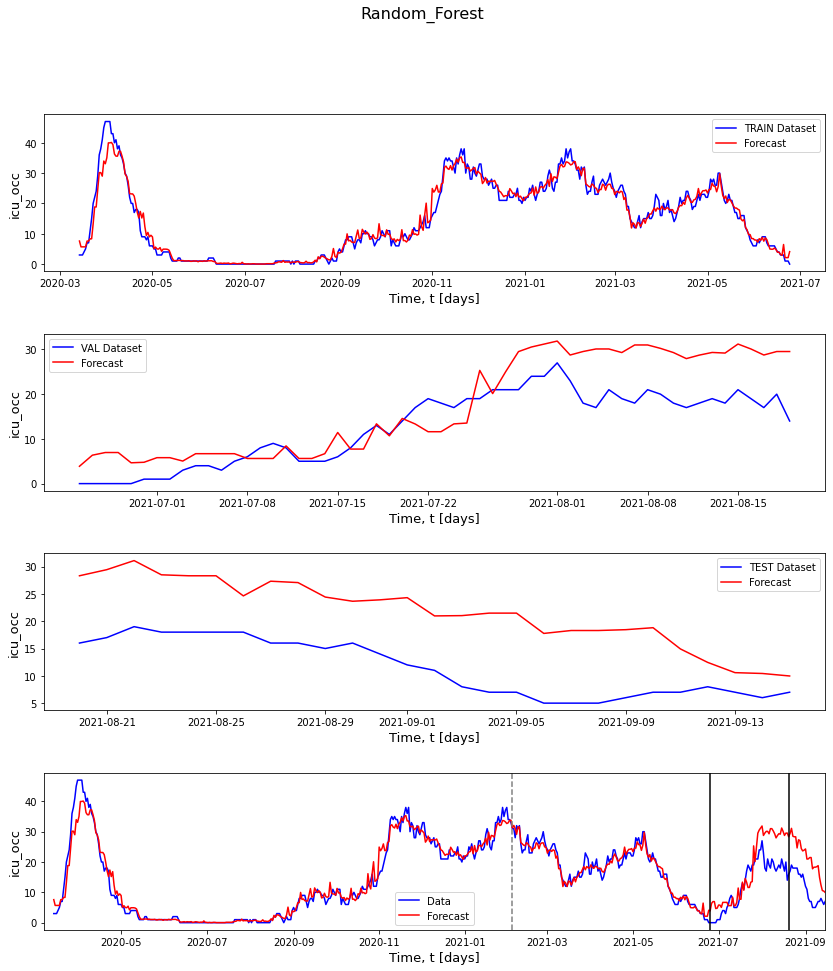

In [267]:
# Metrics
metrics['icu_occ']['Random_Forest'] = icu.model_summary(rf_model)
# PLot
icu.model_plot(rf_model)

### Hospital occupancy

In [268]:
# Data
hospital = ForecastingML(df, 'hospital_occ')
hospital.make_splits()
hospital.normalize()
# X
X_train = hospital.scale_df['train']['X']
X_val = hospital.scale_df['val']['X']
X = pd.concat([X_train, X_val]).values
# y
y_train = hospital.split_df['train']['y']
y_val = hospital.split_df['val']['y']
y = pd.concat([y_train, y_val]).values

custom_cv = TimeSeriesSplit(max_train_size=None, n_splits=5)
param_grid = {
    'bootstrap': [False],
    'max_depth': [5, 10, 20, 30, 40],
    'max_features': [1, 2, 3, 4],
    'min_samples_leaf': [3, 4, 5, 7, 10],
    'min_samples_split': [2, 4, 6, 8, 10],
    'n_estimators': [1, 5, 10, 50]}

rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, 
                           param_grid = param_grid, 
                           n_jobs = -1, 
                           cv = custom_cv,
                           verbose = 2)

In [168]:
# Search best model
t0 = time.time()
models = grid_search.fit(X, y)
print('Elapsed time: ', time.time() - t0, '(s)')

# Best parameters for our model
best_grid = models.best_params_
best_grid

Fitting 5 folds for each of 2000 candidates, totalling 10000 fits
Elapsed time:  66.70592999458313 (s)


{'bootstrap': False,
 'max_depth': 30,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 10,
 'n_estimators': 5}

In [269]:
# Fit best model
t0 = time.time()
rf_model = RandomForestRegressor(bootstrap=False,
                                 max_depth=10,
                                 max_features=4,
                                 min_samples_leaf=7, 
                                 min_samples_split=6, 
                                 n_estimators=5,
                                 criterion='mse')
rf_model = rf_model.fit(X_train, y_train)
rf_model.name = 'Random_Forest'
print('Elapsed time: ', time.time() - t0, '(s)')
hospital.model_summary(rf_model)

Elapsed time:  0.020677804946899414 (s)


,train,val,test
rmse,3.953669,8.254561,9.380738
mse,15.631501,68.137783,87.998252
mae,8.176078,61.315841,84.583987
mape,0.239962,0.857164,1.577092


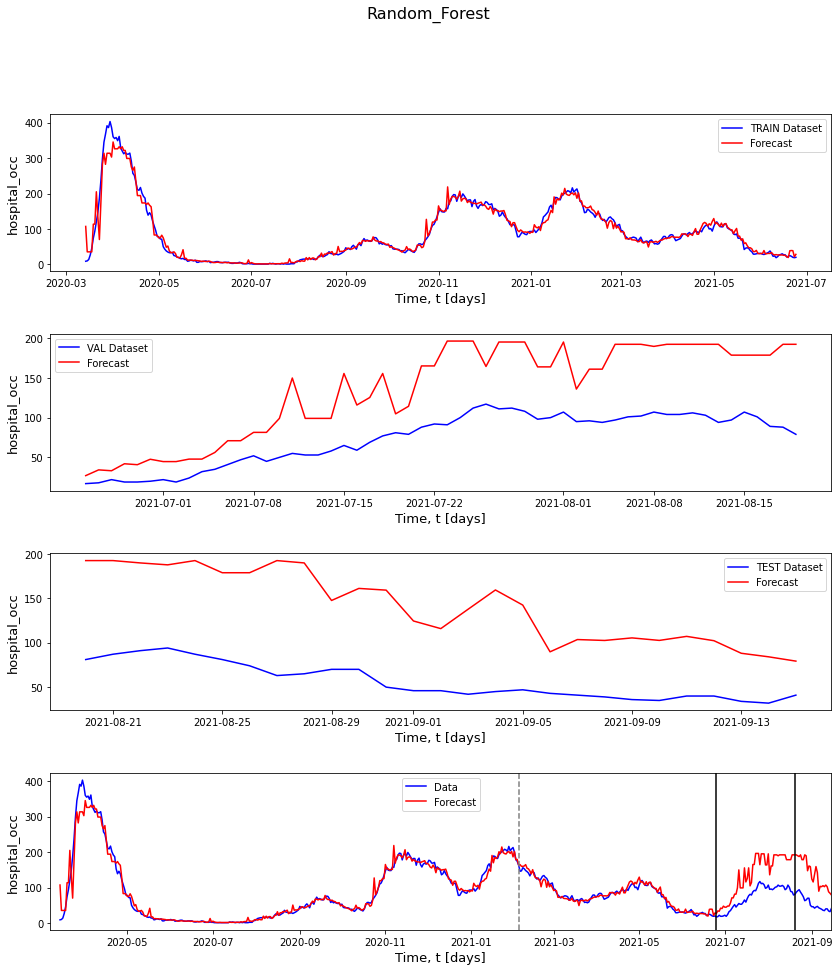

In [270]:
# Metrics
metrics['hospital_occ']['Random_Forest'] = hospital.model_summary(rf_model)
# Plot
hospital.model_plot(rf_model)

## Support Vector Regression (SVR)<a name="SVR"></a>
SVR is built based on the concept of Support Vector Machine (SVM). SVR gives us the flexibility to define how much error is acceptable in our model. The free parameters in the model are C and $\epsilon$ to choose how tolerant the model will be of errors, both through an acceptable error margin and through tuning our tolerance of falling outside that acceptable error rate.

### Daily cases

In [171]:
# Data
daily = ForecastingML(df, 'daily_cases')
daily.make_splits()
daily.normalize()
# X
X_train = daily.scale_df['train']['X']
X_val = daily.scale_df['val']['X']
X = pd.concat([X_train, X_val]).values
# y
y_train = daily.split_df['train']['y']
y_val = daily.split_df['val']['y']
y = pd.concat([y_train, y_val]).values

custom_cv = TimeSeriesSplit(max_train_size=None, n_splits=5)
param_grid={"C": [1e-1, 1e0, 1e1, 1e2, 2e3, 3e3, 4e4],
            "epsilon": [0.05, 0.1, 0.5, 1, 5, 10, 20, 50],
            "gamma": np.logspace(-5, 0, 6),
            "kernel": ['rbf', 'sigmoid'],}
#             "degree": [1, 2, 3, 4, 5, 6, 7, 8]}

# Create the model
svr = SVR()
grid_search = GridSearchCV(estimator = svr, 
                           param_grid = param_grid, 
                           n_jobs = -1, 
                           cv = custom_cv,
                           verbose = 2)

In [172]:
# Search best model
t0 = time.time()
models = grid_search.fit(X, y)
print('Elapsed time: ', time.time() - t0, '(s)')

# Best parameters for our model
best_grid = models.best_params_
best_grid

Fitting 5 folds for each of 672 candidates, totalling 3360 fits
Elapsed time:  10.929567098617554 (s)


{'C': 3000.0, 'epsilon': 20, 'gamma': 0.01, 'kernel': 'sigmoid'}

In [173]:
# Fit best model
t0 = time.time()
svr_model = SVR(C=3e3,
                epsilon=20,
                gamma=1e-2,
                kernel='sigmoid',)
svr_model = svr_model.fit(X_train, y_train)
svr_model.name = 'SVR'
print('Elapsed time: ', time.time() - t0, '(s)')
daily.model_summary(svr_model)

Elapsed time:  0.017569541931152344 (s)


,train,val,test
rmse,5.688775e+00,8.948239,5.821282
mse,3.236216e+01,80.070982,33.887321
mae,2.398979e+01,63.449325,27.454282
mape,8.479586e+14,0.298129,0.397082


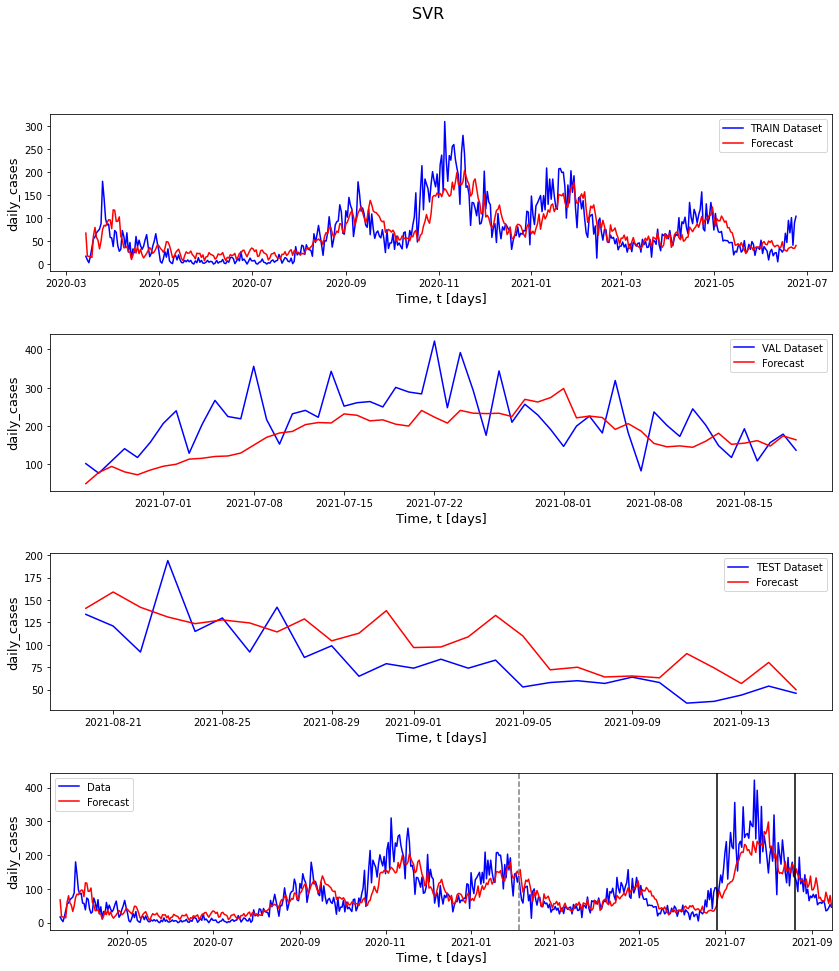

In [174]:
# Metrics
metrics['daily_cases']['SVR'] = daily.model_summary(svr_model)
# Plot
daily.model_plot(svr_model)

### ICU occupancy

In [175]:
# Data
icu = ForecastingML(df, 'icu_occ')
icu.make_splits()
icu.normalize()
# X
X_train = icu.scale_df['train']['X']
X_val = icu.scale_df['val']['X']
X = pd.concat([X_train, X_val]).values
# y
y_train = icu.split_df['train']['y']
y_val = icu.split_df['val']['y']
y = pd.concat([y_train, y_val]).values

custom_cv = TimeSeriesSplit(max_train_size=None, n_splits=5)
param_grid={"C": [1e-1, 1e0, 1e1, 1e2, 2e3, 3e3, 4e4, 5e4],
            "epsilon": [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20],
            "gamma": np.logspace(-6, 0, 7),
            "kernel": ['rbf', 'sigmoid'],}
#             "degree": [1, 2, 3, 4, 5, 6, 7, 8]}

# Create the model
svr = SVR()
grid_search = GridSearchCV(estimator = svr, 
                           param_grid = param_grid, 
                           n_jobs = -1, 
                           cv = custom_cv,
                           verbose = 2)

In [176]:
# Search best model
t0 = time.time()
models = grid_search.fit(X, y)
print('Elapsed time: ', time.time() - t0, '(s)')

# Best parameters for our model
best_grid = models.best_params_
best_grid

Fitting 5 folds for each of 1008 candidates, totalling 5040 fits
Elapsed time:  50.77514386177063 (s)


{'C': 40000.0, 'epsilon': 0.001, 'gamma': 1e-05, 'kernel': 'sigmoid'}

In [177]:
# Fit best model
t0 = time.time()
svr_model = SVR(C=4e4,
                epsilon=0.001,
                gamma=1e-5,
                kernel='sigmoid',)
svr_model = svr_model.fit(X_train, y_train)
svr_model.name = 'SVR'
print('Elapsed time: ', time.time() - t0, '(s)')
icu.model_summary(svr_model)

Elapsed time:  0.014924764633178711 (s)


,train,val,test
rmse,2.284742e+00,2.882337e+00,2.815049
mse,5.220044e+00,8.307868e+00,7.924501
mae,3.279276e+00,7.582003e+00,6.556966
mape,4.091934e+14,3.122008e+15,0.761696


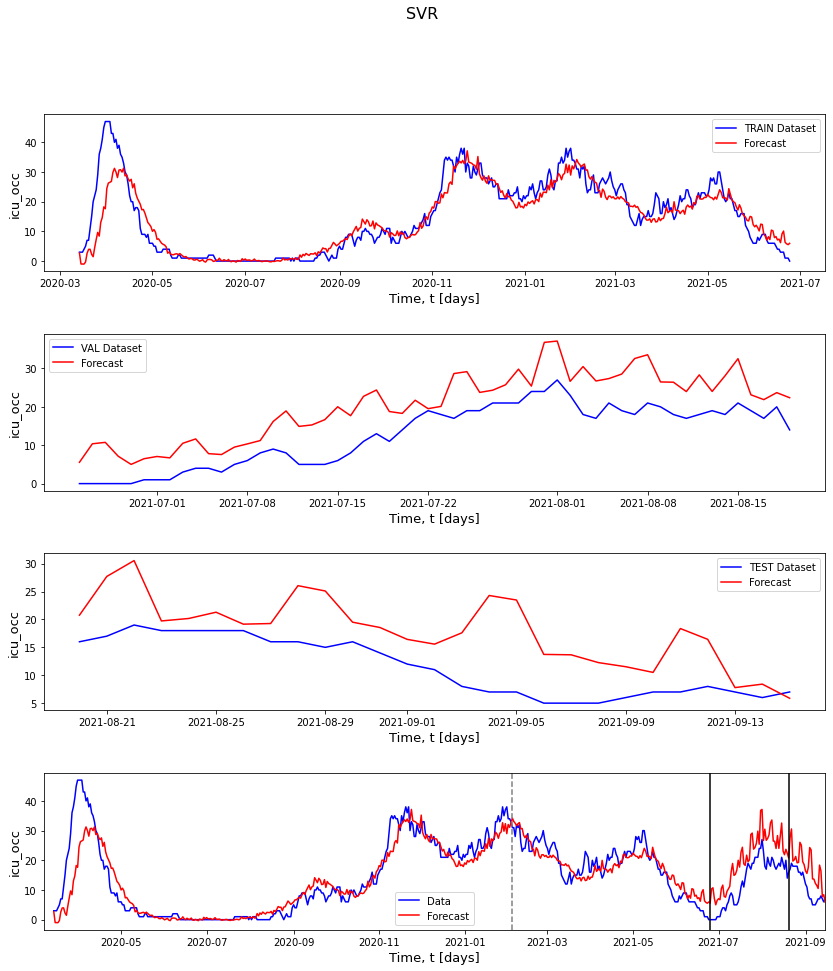

In [178]:
# Metrics
metrics['icu_occ']['SVR'] = icu.model_summary(svr_model)
# Plot
icu.model_plot(svr_model)

### Hospital occupancy

In [179]:
# Data
hospital = ForecastingML(df, 'hospital_occ')
hospital.make_splits()
hospital.normalize()
# X
X_train = hospital.scale_df['train']['X']
X_val = hospital.scale_df['val']['X']
X = pd.concat([X_train, X_val]).values
# y
y_train = hospital.split_df['train']['y']
y_val = hospital.split_df['val']['y']
y = pd.concat([y_train, y_val]).values

custom_cv = TimeSeriesSplit(max_train_size=None, n_splits=5)
param_grid={"C": [1e-1, 1e0, 1e1, 1e2, 2e3, 3e3, 4e4, 5e4],
            "epsilon": [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20],
            "gamma": np.logspace(-6, 0, 7),
            "kernel": ['rbf', 'sigmoid'],}
#             "degree": [1, 2, 3, 4, 5, 6, 7, 8]}

# Create the model
svr = SVR()
grid_search = GridSearchCV(estimator = svr, 
                           param_grid = param_grid, 
                           n_jobs = -1, 
                           cv = custom_cv,
                           verbose = 2)

In [180]:
# Search best model
t0 = time.time()
models = grid_search.fit(X, y)
print('Elapsed time: ', time.time() - t0, '(s)')

# Best parameters for our model
best_grid = models.best_params_
best_grid

Fitting 5 folds for each of 1008 candidates, totalling 5040 fits
Elapsed time:  33.91500663757324 (s)


{'C': 40000.0, 'epsilon': 0.001, 'gamma': 0.0001, 'kernel': 'sigmoid'}

In [181]:
# Fit best model
t0 = time.time()
svr_model = SVR(C=4e4,
                epsilon=0.001,
                gamma=1e-4,
                kernel='sigmoid',)
svr_model = svr_model.fit(X_train, y_train)
svr_model.name = 'SVR'
print('Elapsed time: ', time.time() - t0, '(s)')
hospital.model_summary(svr_model)

Elapsed time:  0.01567554473876953 (s)


,train,val,test
rmse,6.267500,6.301356,6.109358
mse,39.281560,39.707082,37.324257
mae,18.146563,34.010464,33.181910
mape,0.375892,0.491712,0.614183


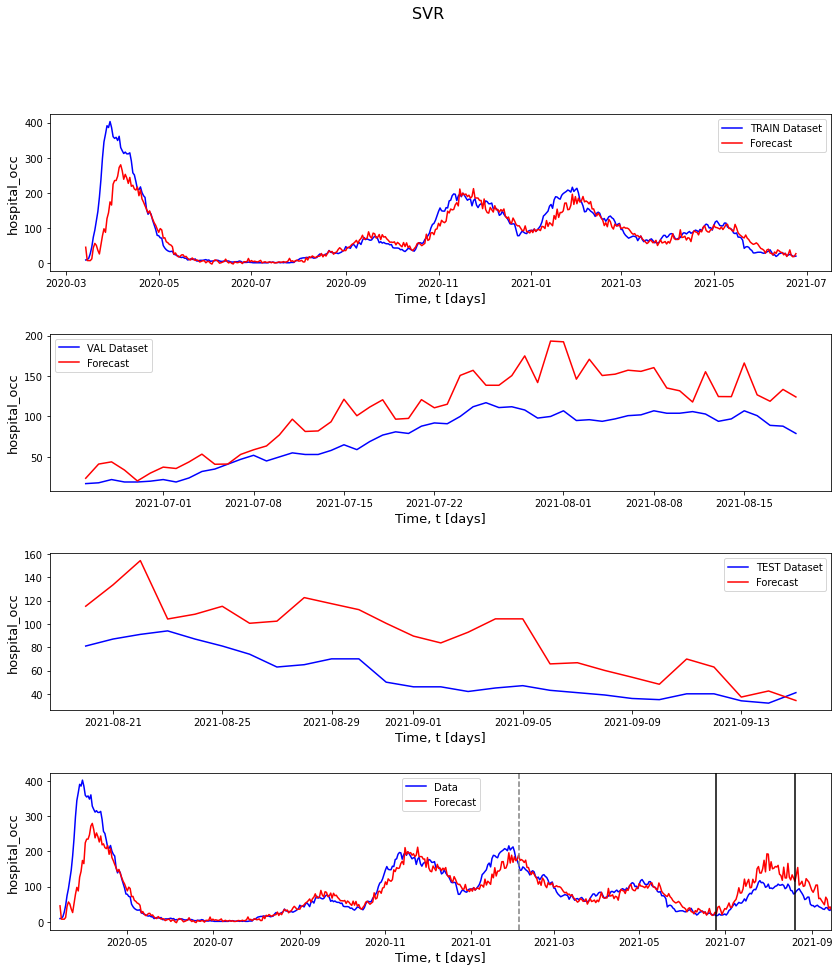

In [182]:
# Metrics
metrics['hospital_occ']['SVR'] = hospital.model_summary(svr_model)
# Plot
hospital.model_plot(svr_model)

## Kernel Ridge Regression (KRR)<a name="KRR"></a>

Kernel ridge regression (KRR) combines ridge regression (linear least squares with L2-norm regularization) with the kernel trick.

Both KRR and SVR learn a non-linear function by applying the kernel trick. They differ in the loss functions (ridge verse epsilon-insensitive loss). In contrast to SVR, fitting a KRR can be done in closed-form and is typically faster for medium-sized datasets. On the other hand, the learned model is non-sparse and thus slower than SVR at prediction-time.

### Daily cases

In [183]:
# Data
daily = ForecastingML(df, 'daily_cases')
daily.make_splits()
daily.normalize()
# X
X_train = daily.scale_df['train']['X']
X_val = daily.scale_df['val']['X']
X = pd.concat([X_train, X_val]).values
# y
y_train = daily.split_df['train']['y']
y_val = daily.split_df['val']['y']
y = pd.concat([y_train, y_val]).values

custom_cv = TimeSeriesSplit(max_train_size=None, n_splits=5)
param_grid={"alpha": [30, 10, 1e0, 0.1, 1e-2, 1e-3, 1e-4],
            "coef0": [1, 2, 5, 10],
            "gamma": np.logspace(-5, 0, 6),
            "kernel": ['rbf', 'sigmoid'],}
#             "degree": [1, 2, 3, 4, 5, 6, 7, 8]}

# Create the model
krr = KernelRidge()
grid_search = GridSearchCV(estimator = krr, 
                           param_grid = param_grid, 
                           n_jobs = -1, 
                           cv = custom_cv,
                           verbose = 2)

In [184]:
# Search best model
t0 = time.time()
models = grid_search.fit(X, y)
print('Elapsed time: ', time.time() - t0, '(s)')

# Best parameters for our model
best_grid = models.best_params_
best_grid

Fitting 5 folds for each of 336 candidates, totalling 1680 fits
Elapsed time:  3.364039421081543 (s)


{'alpha': 0.0001, 'coef0': 1, 'gamma': 0.0001, 'kernel': 'sigmoid'}

In [185]:
# Best model
t0 = time.time()
krr_model = KernelRidge(alpha=0.0001,
                        coef0=1,
                        gamma=0.0001,
                        kernel='sigmoid')
krr_model = krr_model.fit(X_train, y_train)
krr_model.name = 'KRR'
print('Elapsed time: ', time.time() - t0, '(s)')
daily.model_summary(krr_model)

Elapsed time:  0.021941423416137695 (s)


,train,val,test
rmse,5.689070e+00,8.709852,6.456639
mse,3.236552e+01,75.861523,41.688190
mae,2.412715e+01,60.607045,37.994122
mape,8.095735e+14,0.296556,0.560832


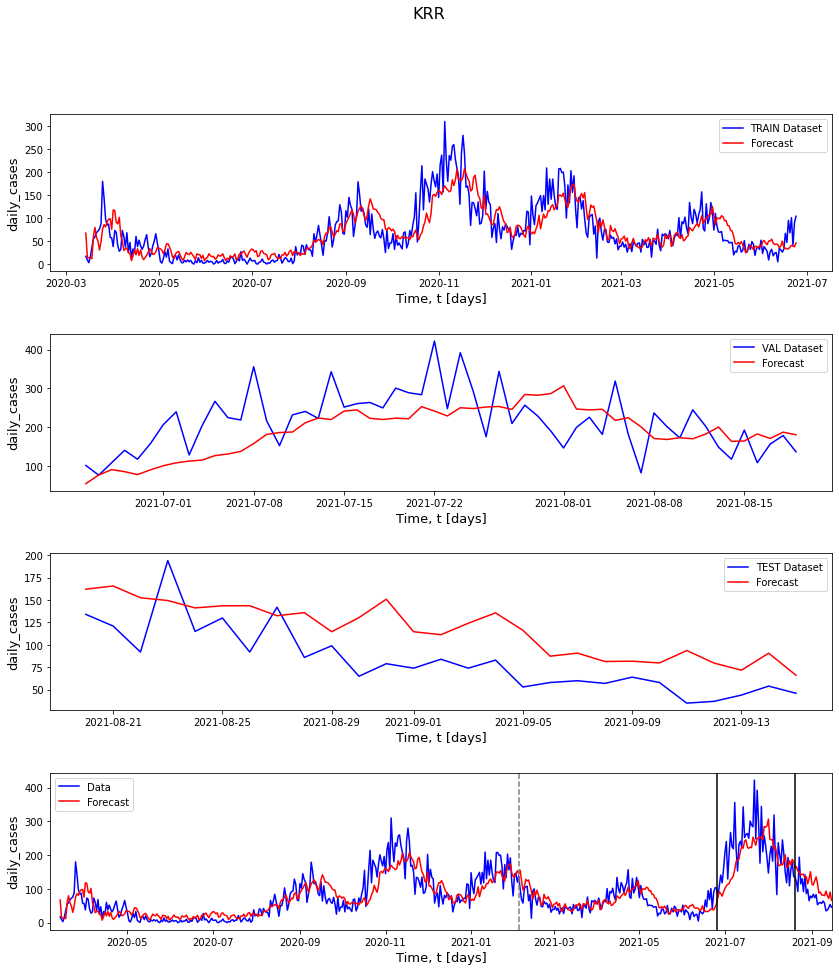

In [186]:
# Metrics
metrics['daily_cases']['KRR'] = daily.model_summary(krr_model)
# Plot
daily.model_plot(krr_model)

### ICU occupancy

In [187]:
# Data
icu = ForecastingML(df, 'icu_occ')
icu.make_splits()
icu.normalize()
# X
X_train = icu.scale_df['train']['X']
X_val = icu.scale_df['val']['X']
X = pd.concat([X_train, X_val]).values
# y
y_train = icu.split_df['train']['y']
y_val = icu.split_df['val']['y']
y = pd.concat([y_train, y_val]).values

custom_cv = TimeSeriesSplit(max_train_size=None, n_splits=5)
param_grid={"alpha": [30, 10, 1e0, 0.1, 1e-2, 1e-3, 1e-4],
            "coef0": [1, 2, 5, 10],
            "gamma": np.logspace(-5, 0, 6),
            "kernel": ['rbf', 'sigmoid'],}
#             "degree": [1, 2, 3, 4, 5, 6, 7, 8]}

# Create the model
krr = KernelRidge()
grid_search = GridSearchCV(estimator = krr, 
                           param_grid = param_grid, 
                           n_jobs = -1, 
                           cv = custom_cv,
                           verbose = 2)

In [188]:
# Search best model
t0 = time.time()
models = grid_search.fit(X, y)
print('Elapsed time: ', time.time() - t0, '(s)')

# Best parameters for our model
best_grid = models.best_params_
best_grid

Fitting 5 folds for each of 336 candidates, totalling 1680 fits
Elapsed time:  3.3851401805877686 (s)


{'alpha': 0.1, 'coef0': 1, 'gamma': 0.1, 'kernel': 'rbf'}

In [189]:
# Best model
t0 = time.time()
krr_model = KernelRidge(alpha=0.1,
                        coef0=1,
                        gamma=0.1,
                        kernel='rbf')
krr_model = krr_model.fit(X_train, y_train)
krr_model.name = 'KRR'
print('Elapsed time: ', time.time() - t0, '(s)')
icu.model_summary(krr_model)

Elapsed time:  0.019479036331176758 (s)


,train,val,test
rmse,1.694328e+00,2.594431e+00,2.945140
mse,2.870747e+00,6.731071e+00,8.673848
mae,2.139116e+00,4.934859e+00,6.863053
mape,3.692836e+14,2.074378e+15,0.708745


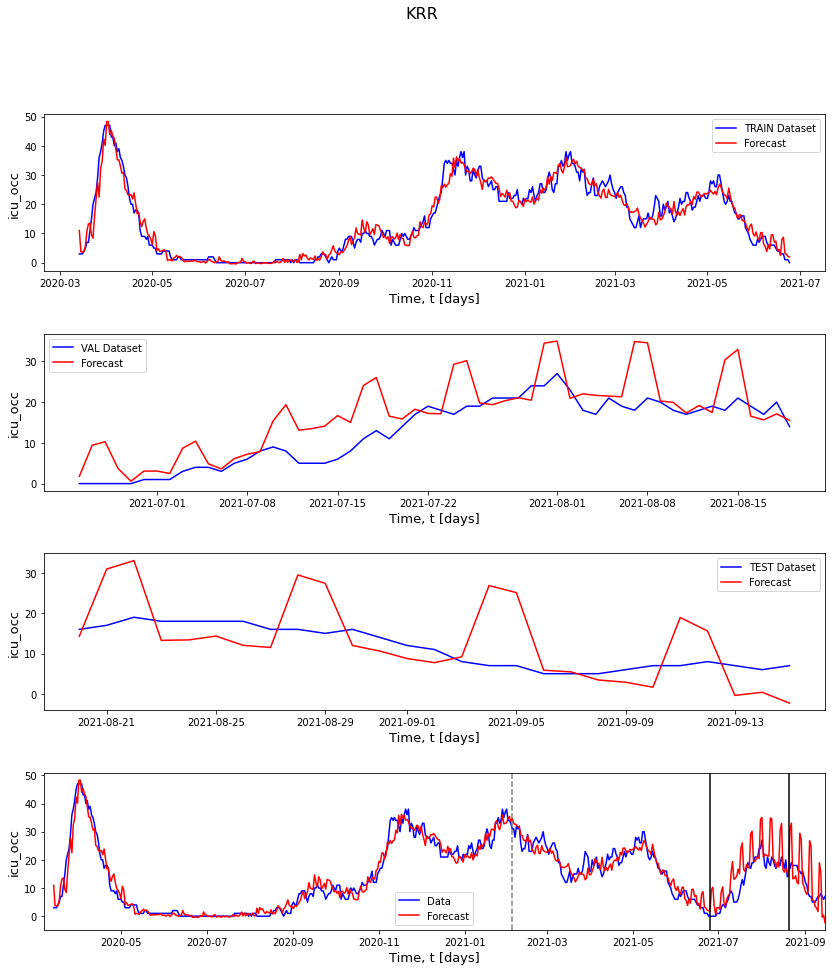

In [190]:
# Metrics
metrics['icu_occ']['KRR'] = icu.model_summary(krr_model)
# Plot
icu.model_plot(krr_model)

### Hospital occupancy

In [191]:
# Data
hospital = ForecastingML(df, 'hospital_occ')
hospital.make_splits()
hospital.normalize()
# X
X_train = hospital.scale_df['train']['X']
X_val = hospital.scale_df['val']['X']
X = pd.concat([X_train, X_val]).values
# y
y_train = hospital.split_df['train']['y']
y_val = hospital.split_df['val']['y']
y = pd.concat([y_train, y_val]).values

custom_cv = TimeSeriesSplit(max_train_size=None, n_splits=5)
param_grid={"alpha": [30, 10, 1e0, 0.1, 1e-2, 1e-3, 1e-4],
            "coef0": [1, 2, 5, 10],
            "gamma": np.logspace(-5, 0, 6),
            "kernel": ['rbf', 'sigmoid'],}
#             "degree": [1, 2, 3, 4, 5, 6, 7, 8]}

# Create the model
krr = KernelRidge()
grid_search = GridSearchCV(estimator = krr, 
                           param_grid = param_grid, 
                           n_jobs = -1, 
                           cv = custom_cv,
                           verbose = 2)

In [192]:
# Search best model
t0 = time.time()
models = grid_search.fit(X, y)
print('Elapsed time: ', time.time() - t0, '(s)')

# Best parameters for our model
best_grid = models.best_params_
best_grid

Fitting 5 folds for each of 336 candidates, totalling 1680 fits
Elapsed time:  3.408362865447998 (s)


{'alpha': 0.0001, 'coef0': 1, 'gamma': 0.001, 'kernel': 'sigmoid'}

In [193]:
# Best model
t0 = time.time()
krr_model = KernelRidge(alpha=0.0001,
                        coef0=1,
                        gamma=0.001,
                        kernel='sigmoid')
krr_model = krr_model.fit(X_train, y_train)
krr_model.name = 'KRR'
print('Elapsed time: ', time.time() - t0, '(s)')
hospital.model_summary(krr_model)

Elapsed time:  0.017966747283935547 (s)


,train,val,test
rmse,4.806747,6.172611,7.397054
mse,23.104820,38.101133,54.716401
mae,14.620090,30.621969,49.953348
mape,0.472475,0.487877,0.974414


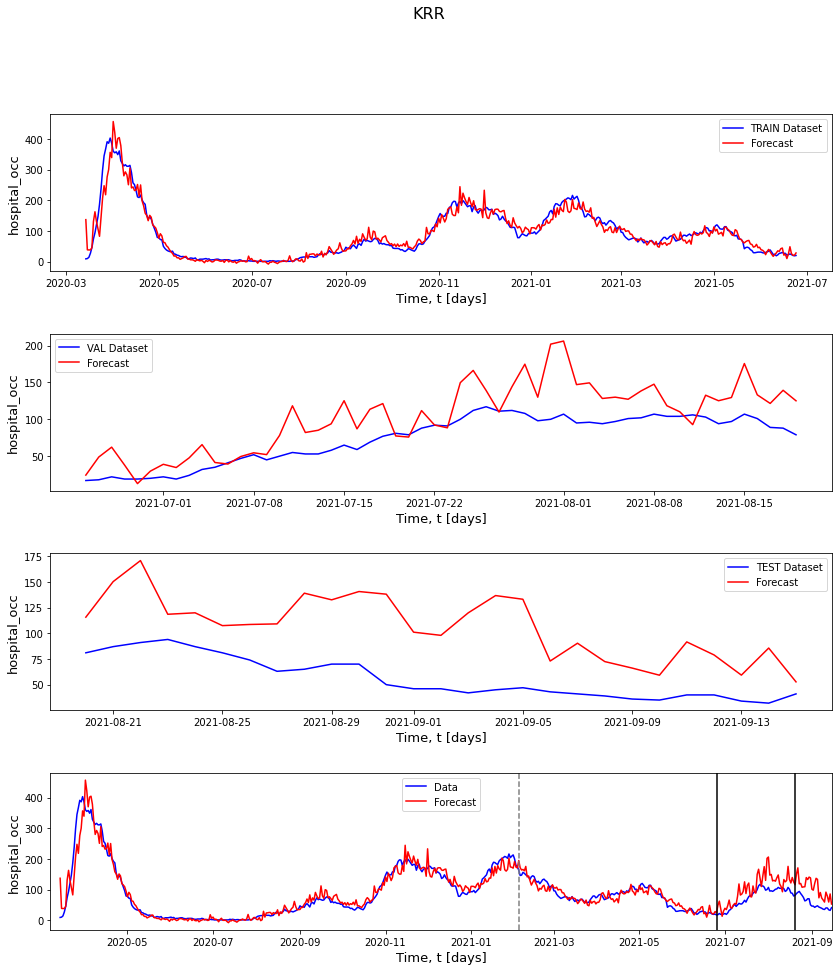

In [194]:
# Metrics
metrics['hospital_occ']['KRR'] = hospital.model_summary(krr_model)
# Plot
hospital.model_plot(krr_model)

## Gradient Boosting Regressor<a name="GBR"></a>

Gradient Boosting (GB) for regression builds an additive model in a forward stage-wise fashion. It allows for the optimization of arbitrary differentiable loss functions. In each stage a regression tree is fit on the negative gradient of the given loss function.

### Daily cases

In [195]:
# Data
daily = ForecastingML(df, 'daily_cases')
daily.make_splits()
daily.normalize()
# X
X_train = daily.scale_df['train']['X']
X_val = daily.scale_df['val']['X']
X = pd.concat([X_train, X_val]).values
# y
y_train = daily.split_df['train']['y']
y_val = daily.split_df['val']['y']
y = pd.concat([y_train, y_val]).values

custom_cv = TimeSeriesSplit(max_train_size=None, n_splits=5)
param_grid = {"n_estimators": [5, 10, 50, 100, 200, 300],
              "learning_rate": [0.001, 0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8],
              "max_depth": [1, 5, 10, 20, 30, 40, 50, 80],}

# Create the model
gb = GradientBoostingRegressor(random_state=0, loss='ls')
grid_search = GridSearchCV(estimator = gb, 
                           param_grid = param_grid, 
                           n_jobs = -1, 
                           cv = custom_cv,
                           verbose = 2)

In [196]:
# Search best model
t0 = time.time()
models = grid_search.fit(X, y)
print('Elapsed time: ', time.time() - t0, '(s)')

# Best parameters for our model
best_grid = models.best_params_
best_grid

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
Elapsed time:  127.86835050582886 (s)


{'learning_rate': 0.4, 'max_depth': 1, 'n_estimators': 50}

In [197]:
# Best model
t0 = time.time()
gb_model = GradientBoostingRegressor(learning_rate=0.4,
                                     max_depth=1,
                                     n_estimators=50,
                                     random_state=0,
                                     loss='ls')
gb_model = gb_model.fit(X_train, y_train)
gb_model.name = 'GB'
print('Elapsed time: ', time.time() - t0, '(s)')
daily.model_summary(gb_model)

Elapsed time:  0.06183457374572754 (s)


,train,val,test
rmse,4.996275e+00,9.158876,7.743894
mse,2.496277e+01,83.885009,59.967892
mae,1.889102e+01,65.236358,53.982303
mape,5.972026e+14,0.294340,0.773356


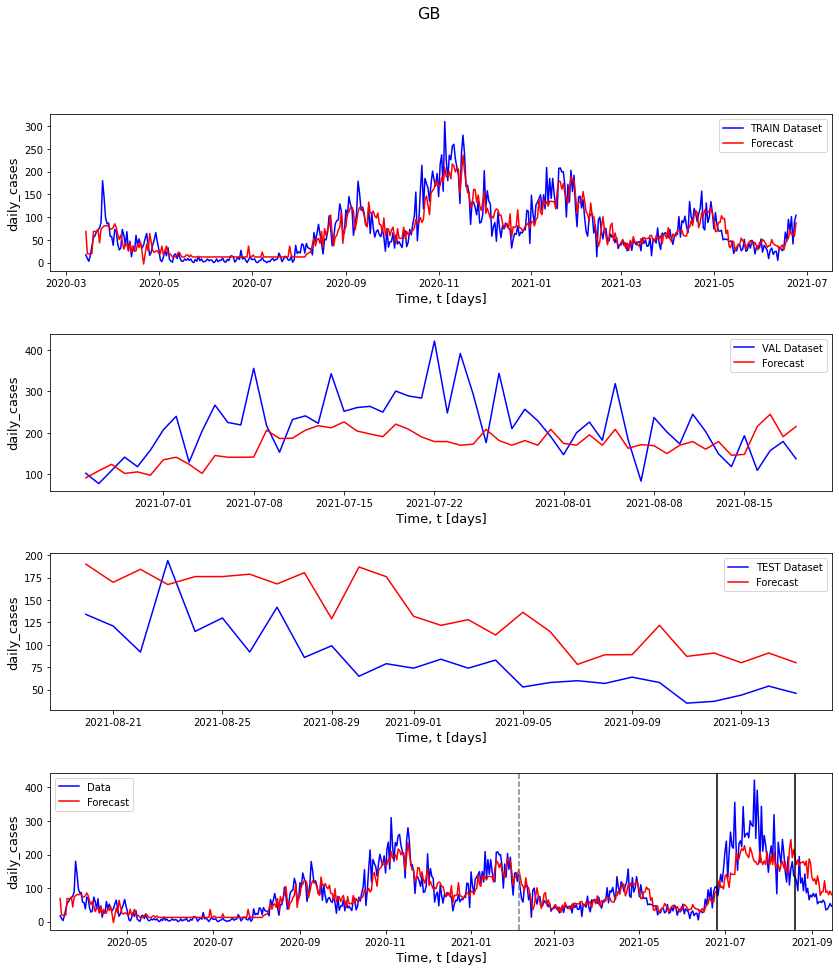

In [198]:
# Metrics
metrics['daily_cases']['GB'] = daily.model_summary(gb_model)
# Plot
daily.model_plot(gb_model)

### ICU occupancy

In [199]:
# Data
icu = ForecastingML(df, 'icu_occ')
icu.make_splits()
icu.normalize()
# X
X_train = icu.scale_df['train']['X']
X_val = icu.scale_df['val']['X']
X = pd.concat([X_train, X_val]).values
# y
y_train = icu.split_df['train']['y']
y_val = icu.split_df['val']['y']
y = pd.concat([y_train, y_val]).values

custom_cv = TimeSeriesSplit(max_train_size=None, n_splits=5)
param_grid = {"n_estimators": [5, 10, 50, 100, 200, 300],
              "learning_rate": [0.001, 0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8],
              "max_depth": [1, 5, 10, 20, 30, 40, 50, 80],}

# Create the model
gb = GradientBoostingRegressor(random_state=0, loss='ls')
grid_search = GridSearchCV(estimator = gb, 
                           param_grid = param_grid, 
                           n_jobs = -1, 
                           cv = custom_cv,
                           verbose = 2)

In [200]:
# Search best model
t0 = time.time()
models = grid_search.fit(X, y)
print('Elapsed time: ', time.time() - t0, '(s)')

# Best parameters for our model
best_grid = models.best_params_
best_grid

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
Elapsed time:  106.9863498210907 (s)


{'learning_rate': 0.4, 'max_depth': 1, 'n_estimators': 200}

In [201]:
# Best model
t0 = time.time()
gb_model = GradientBoostingRegressor(learning_rate=0.4,
                                     max_depth=1,
                                     n_estimators=200,
                                     random_state=0,
                                     loss='ls')
gb_model = gb_model.fit(X_train, y_train)
gb_model.name = 'GB'
print('Elapsed time: ', time.time() - t0, '(s)')
icu.model_summary(gb_model)

Elapsed time:  0.1586151123046875 (s)


,train,val,test
rmse,1.400316e+00,2.566012e+00,2.702836
mse,1.960884e+00,6.584418e+00,7.305324
mae,1.502627e+00,5.579489e+00,6.014934
mape,2.126909e+14,1.484237e+15,0.594905


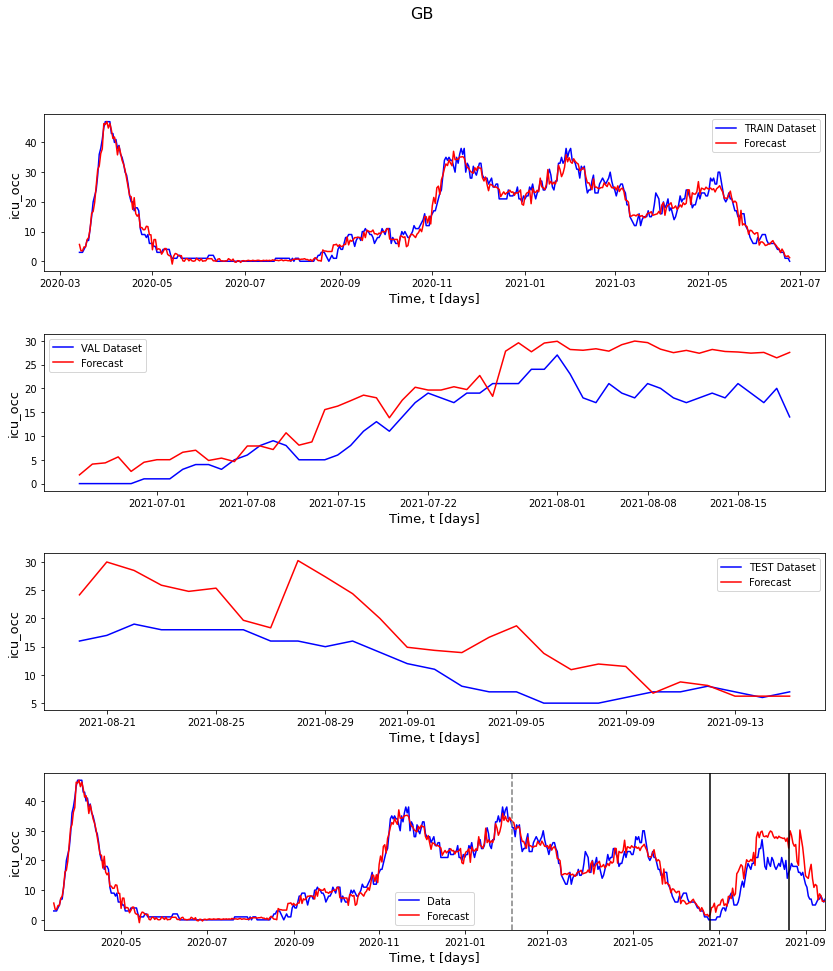

In [202]:
# Metrics
metrics['icu_occ']['GB'] = icu.model_summary(gb_model)
# Plot
icu.model_plot(gb_model)

### Hospital occupancy

In [203]:
# Data
hospital = ForecastingML(df, 'hospital_occ')
hospital.make_splits()
hospital.normalize()
# X
X_train = hospital.scale_df['train']['X']
X_val = hospital.scale_df['val']['X']
X = pd.concat([X_train, X_val]).values
# y
y_train = hospital.split_df['train']['y']
y_val = hospital.split_df['val']['y']
y = pd.concat([y_train, y_val]).values

custom_cv = TimeSeriesSplit(max_train_size=None, n_splits=5)
param_grid = {"n_estimators": [5, 10, 50, 100, 200, 300],
              "learning_rate": [0.001, 0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8],
              "max_depth": [1, 5, 10, 20, 30, 40, 50, 80],}

# Create the model
gb = GradientBoostingRegressor(random_state=0, loss='ls')
grid_search = GridSearchCV(estimator = gb, 
                           param_grid = param_grid, 
                           n_jobs = -1, 
                           cv = custom_cv,
                           verbose = 2)

In [204]:
# Search best model
t0 = time.time()
models = grid_search.fit(X, y)
print('Elapsed time: ', time.time() - t0, '(s)')

# Best parameters for our model
best_grid = models.best_params_
best_grid

Fitting 5 folds for each of 384 candidates, totalling 1920 fits
Elapsed time:  118.95614504814148 (s)


{'learning_rate': 0.6, 'max_depth': 1, 'n_estimators': 300}

In [205]:
# Best model
t0 = time.time()
gb_model = GradientBoostingRegressor(learning_rate=0.6,
                                     max_depth=1,
                                     n_estimators=300,
                                     random_state=0,
                                     loss='ls')
gb_model = gb_model.fit(X_train, y_train)
gb_model.name = 'GB'
print('Elapsed time: ', time.time() - t0, '(s)')
hospital.model_summary(gb_model)

Elapsed time:  0.3130676746368408 (s)


,train,val,test
rmse,2.824894,5.993373,6.572913
mse,7.980028,35.920515,43.203181
mae,5.986974,29.535174,37.546017
mape,0.268277,0.433398,0.651590


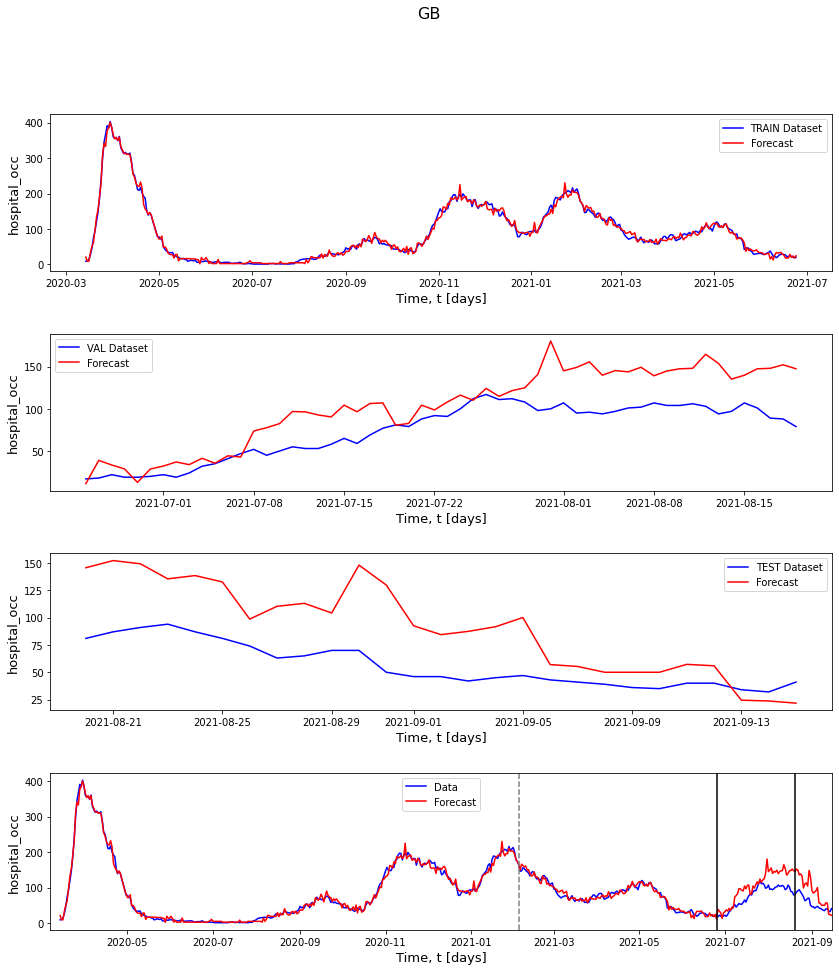

In [206]:
# Metrics
metrics['hospital_occ']['GB'] = hospital.model_summary(gb_model)
# Plot
hospital.model_plot(gb_model)

## K-NN<a name="KNN"></a>

K-Nearest-Neighbor algorithm can be used for classification and regression. It uses feature similarity to predict the values of any new data points.

### Daily cases

In [207]:
# Data
daily = ForecastingML(df, 'daily_cases')
daily.make_splits()
daily.normalize()
# X
X_train = daily.scale_df['train']['X']
X_val = daily.scale_df['val']['X']
X = pd.concat([X_train, X_val]).values
# y
y_train = daily.split_df['train']['y']
y_val = daily.split_df['val']['y']
y = pd.concat([y_train, y_val]).values

custom_cv = TimeSeriesSplit(max_train_size=None, n_splits=5)
param_grid = {"n_neighbors": list(range(1, 30, 1))}
# Create the model
knn = KNeighborsRegressor()
grid_search = GridSearchCV(estimator = knn, 
                           param_grid = param_grid, 
                           n_jobs = -1, 
                           cv = custom_cv,
                           verbose = 2)

In [208]:
# Search best model
t0 = time.time()
models = grid_search.fit(X, y)
print('Elapsed time: ', time.time() - t0, '(s)')

# Best parameters for our model
best_grid = models.best_params_
best_grid

Fitting 5 folds for each of 29 candidates, totalling 145 fits
Elapsed time:  0.29478907585144043 (s)


{'n_neighbors': 19}

In [209]:
# Best model
t0 = time.time()
knn_model = KNeighborsRegressor(n_neighbors=19)
knn_model = knn_model.fit(X_train, y_train)
knn_model.name = 'K-NN'
print('Elapsed time: ', time.time() - t0, '(s)')
daily.model_summary(knn_model)

Elapsed time:  0.003995418548583984 (s)


,train,val,test
rmse,5.645475e+00,11.250418,6.326969
mse,3.187139e+01,126.571894,40.030543
mae,2.273662e+01,108.089286,29.074074
mape,5.135684e+14,0.481340,0.332725


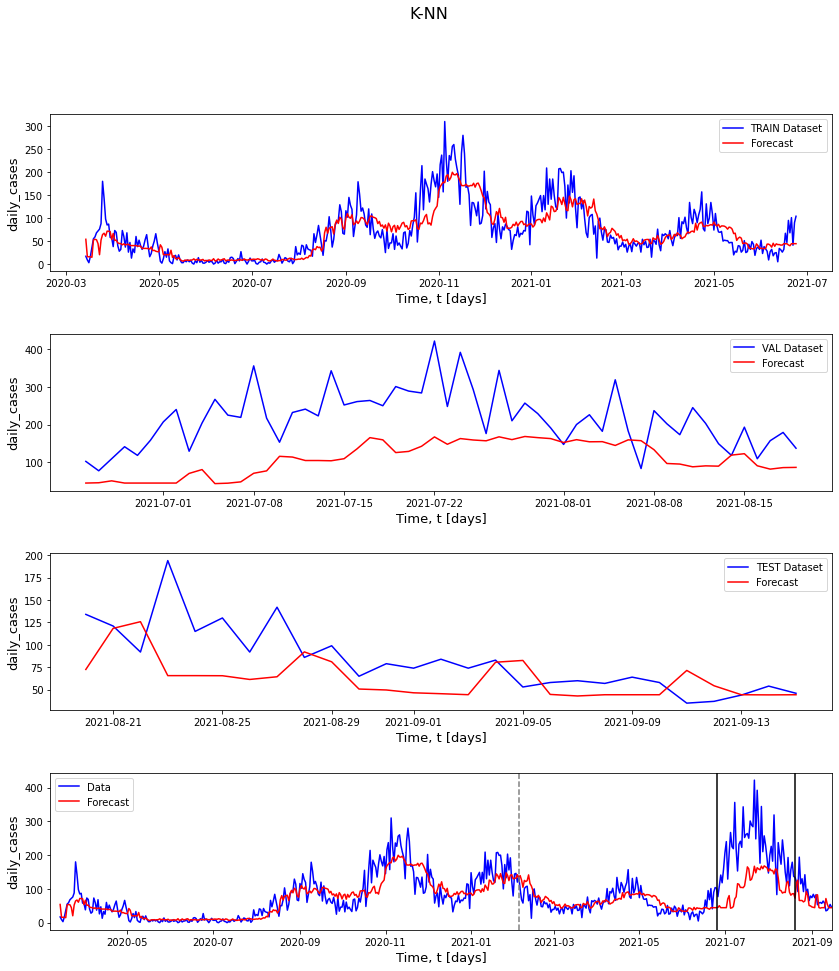

In [210]:
# Metrics
metrics['daily_cases']['K-NN'] = daily.model_summary(knn_model)
# Plot
daily.model_plot(knn_model)

### ICU occupancy

In [211]:
# Data
icu = ForecastingML(df, 'icu_occ')
icu.make_splits()
icu.normalize()
# X
X_train = icu.scale_df['train']['X']
X_val = icu.scale_df['val']['X']
X = pd.concat([X_train, X_val]).values
# y
y_train = icu.split_df['train']['y']
y_val = icu.split_df['val']['y']
y = pd.concat([y_train, y_val]).values

custom_cv = TimeSeriesSplit(max_train_size=None, n_splits=5)
param_grid = {"n_neighbors": list(range(1, 30, 1))}
# Create the model
knn = KNeighborsRegressor()
grid_search = GridSearchCV(estimator = knn, 
                           param_grid = param_grid, 
                           n_jobs = -1, 
                           cv = custom_cv,
                           verbose = 2)

In [212]:
# Search best model
t0 = time.time()
models = grid_search.fit(X, y)
print('Elapsed time: ', time.time() - t0, '(s)')

# Best parameters for our model
best_grid = models.best_params_
best_grid

Fitting 5 folds for each of 29 candidates, totalling 145 fits
Elapsed time:  0.2913086414337158 (s)


{'n_neighbors': 9}

In [213]:
# Best model
t0 = time.time()
knn_model = KNeighborsRegressor(n_neighbors=9)
knn_model = knn_model.fit(X_train, y_train)
knn_model.name = 'K-NN'
print('Elapsed time: ', time.time() - t0, '(s)')
icu.model_summary(knn_model)

Elapsed time:  0.0035016536712646484 (s)


,train,val,test
rmse,1.685364e+00,2.928218e+00,2.954903
mse,2.840452e+00,8.574461e+00,8.731450
mae,1.938272e+00,7.454365e+00,7.526749
mape,2.491307e+14,2.439450e+15,0.727833


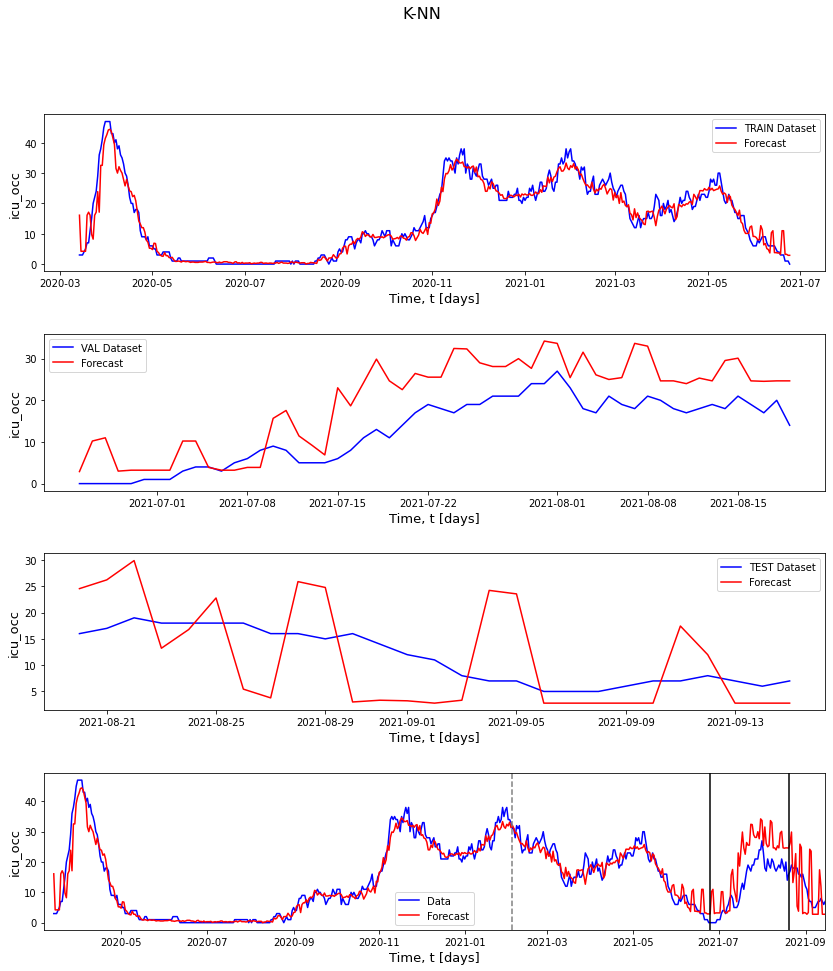

In [214]:
# Metrics
metrics['icu_occ']['K-NN'] = icu.model_summary(knn_model)
# Plot
icu.model_plot(knn_model)

### Hospital occupancy

In [215]:
# Data
hospital = ForecastingML(df, 'hospital_occ')
hospital.make_splits()
hospital.normalize()
# X
X_train = hospital.scale_df['train']['X']
X_val = hospital.scale_df['val']['X']
X = pd.concat([X_train, X_val]).values
# y
y_train = hospital.split_df['train']['y']
y_val = hospital.split_df['val']['y']
y = pd.concat([y_train, y_val]).values

custom_cv = TimeSeriesSplit(max_train_size=None, n_splits=5)
param_grid = {"n_neighbors": list(range(1, 30, 1))}
# Create the model
knn = KNeighborsRegressor()
grid_search = GridSearchCV(estimator = knn, 
                           param_grid = param_grid, 
                           n_jobs = -1, 
                           cv = custom_cv,
                           verbose = 2)

In [216]:
# Search best model
t0 = time.time()
models = grid_search.fit(X, y)
print('Elapsed time: ', time.time() - t0, '(s)')

# Best parameters for our model
best_grid = models.best_params_
best_grid

Fitting 5 folds for each of 29 candidates, totalling 145 fits
Elapsed time:  0.46774983406066895 (s)


{'n_neighbors': 23}

In [217]:
# Best model
t0 = time.time()
knn_model = KNeighborsRegressor(n_neighbors=23)
knn_model = knn_model.fit(X_train, y_train)
knn_model.name = 'K-NN'
print('Elapsed time: ', time.time() - t0, '(s)')
hospital.model_summary(knn_model)

Elapsed time:  0.002991199493408203 (s)


,train,val,test
rmse,5.729083,6.438784,5.415184
mse,32.822391,41.457944,29.324215
mae,15.288833,32.805124,24.214171
mape,0.370155,0.511228,0.428503


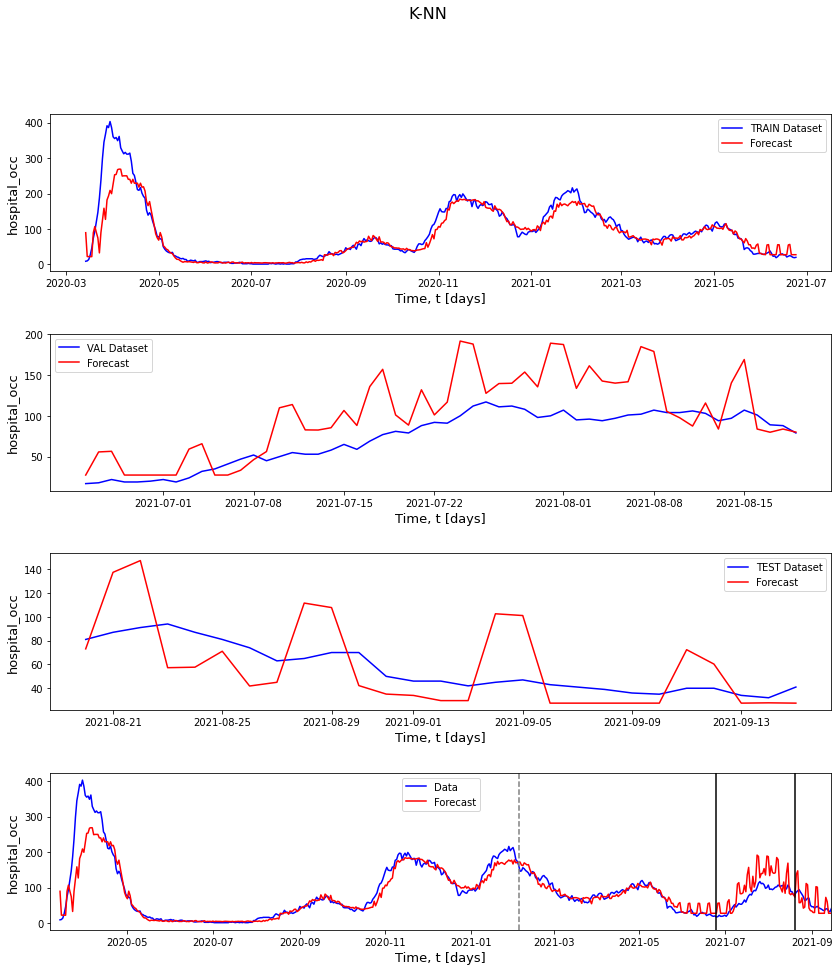

In [218]:
# Metrics
metrics['hospital_occ']['K-NN'] = hospital.model_summary(knn_model)
# Plot
hospital.model_plot(knn_model)

## Metrics Machine Learning

{'daily_cases': {}, 'icu_occ': {}, 'hospital_occ': {}}

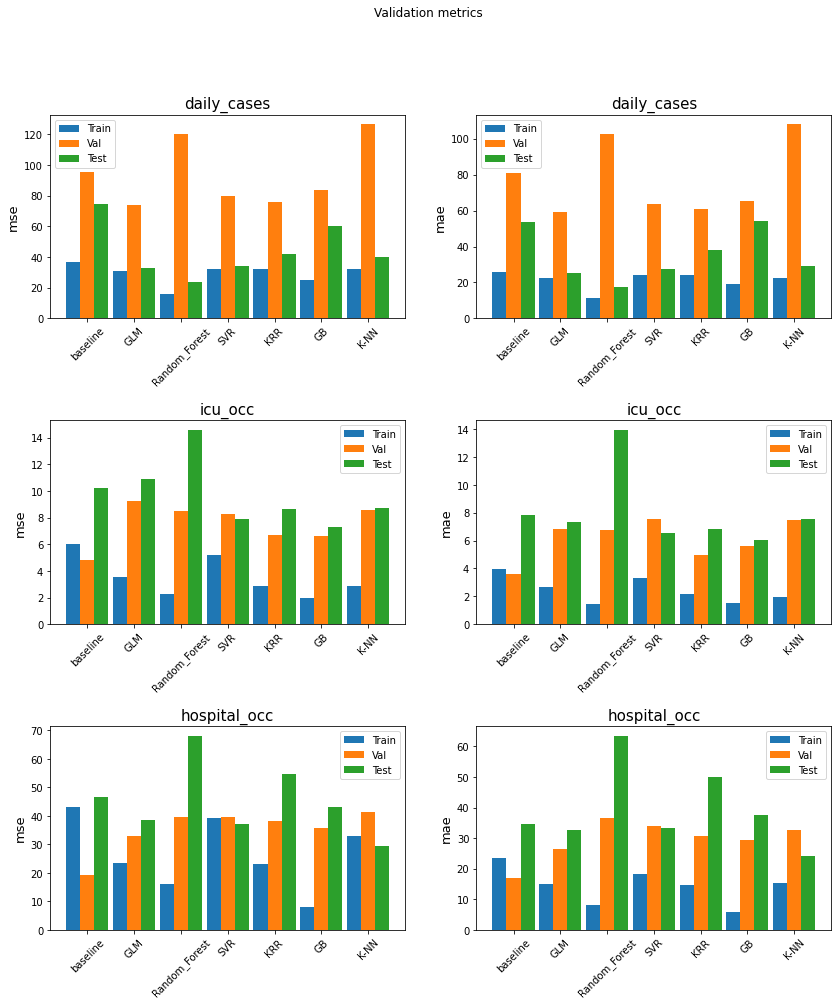

In [234]:
plt.rcParams['figure.figsize'] = (14, 15)
fig, axs = plt.subplots(3, 2)
fig.suptitle('Validation metrics')
for index1, target in enumerate(['daily_cases', 'icu_occ', 'hospital_occ']):
    for index2, m in enumerate(['mse', 'mae']):

        x = np.arange(len(metrics[target].keys()))
        width = 0.3
        train_m = [model.loc[m, 'train'] for model in metrics[target].values()]
        val_m = [model.loc[m, 'val'] for model in metrics[target].values()]
        test_m = [model.loc[m, 'test'] for model in metrics[target].values()]
        
        axs[index1, index2].bar(x - width, train_m, width, label='Train')
        axs[index1, index2].bar(x, val_m, width, label='Val')
        axs[index1, index2].bar(x + width, test_m, width, label='Test')
        axs[index1, index2].set_xticks(ticks=x)
        axs[index1, index2].set_xticklabels(labels=metrics[target].keys(), rotation=45)
        axs[index1, index2].legend(loc='best')
        
        axs[index1, index2].set_title(target, fontsize=15)
#         axs[index1, index2].set_xlabel('Models', fontsize=13)
        axs[index1, index2].set_ylabel(m, fontsize=13)
        plt.subplots_adjust(hspace=0.5)
        
        # Save
        fig_path = figures_path / 'validation_metrics.svg'
        fig.savefig(fig_path)
        

## ARIMA<a name="ARIMA"></a>

An ARIMA model is a class of statistical models for analyzing and forecasting time series data. 
* __AR: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations__.
* I: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
* MA: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.

The parameters of the ARIMA model are defined as follows:

* p: The number of lag observations included in the model, also called the lag order.
* d: The number of times that the raw observations are differenced, also called the degree of differencing.
* q: The size of the moving average window, also called the order of moving average.

A value of 0 can be used for a parameter, which indicates to not use that element of the model. This way, the ARIMA model can be configured to perform the function of an ARMA model, and even a simple AR, I, or MA model.

ARIMA model is useful for multi-step time series forecasting:
* Single-shot: Make the predictions all at once.
* Autoregressive: Make one prediction at a time and feed the output back to the model.

In [ ]:
def evaluate_arima_model(ForecastML, arima_order):
    """
    Evaluate an ARIMA model for a given order (p,d,q) and also forecast the next one time step.
    Train the model using t = (1, ..., t) and predict next time step (t+1).
    Then add (t+1) value from validation dataset to history and fit again the model using t = (1, ..., t, t+1)
    to predict the next instant (t+2), and so on up to t=N where N=len(val)
    Finally, with the predictions and observables from the validation dataset, the metrics MSE, MAE, MAPE y R2
    are calculated.
    Args:
        ForecastML (class): Class with all the information.
        time_step(int): Number of Step Out-of-Sample Forecast
       

    Returns: Errors from predictions using previous iterations.

    """
    try:
        splits = ForecastML.split_df
        time_step = ForecastML.time_step
    
        # prepare training and test dataset (validation+test)
        train = splits['train']['y'].astype('float32')
        val = splits['val']['y'].astype('float32')
        val_new = pd.concat([train.iloc[-time_step:], val])
        
        train = train.iloc[:-time_step]
        history = [x for x in train]
        predictions = list()

        for t in range(len(val_new)-time_step):
            model = sm.tsa.ARIMA(history, order=arima_order)
            model_fit = model.fit(dis=-1)  # All cores
            yhat = model_fit.forecast(steps=time_step)[0]  # Predict steps in future from the last value in history variable.
            predictions.append(yhat[-1])
            history.append(val_new[t])

        # Metrics
        mse = mean_squared_error(val, predictions)
        rmse = sqrt(mean_squared_error(val, predictions))
        mae = mean_absolute_error(val, predictions)
        mape = mean_absolute_percentage_error(val, predictions)
        r2 = r2_score(val, predictions)
        
        return arima_order, rmse, mse, mae, mape
        
    except Exception as e:
#         print(e)
        pass

In [ ]:
def my_map(fun1, obj, iterlist):
    """
    Map() function with a non-iterable and iterable set of parameters.
    Args:
        fun1: Function to use with 2 arguments (obj, element)
        obj: Non iterable or constant object.
        iterlist: List of elements to iterate.

    Returns: Return list from map(func1, obj_cte, iterlist)

    """
    def fun2(x):
        """
        Apply function 1.
        Args:
            x: Element of a list
        Returns: The return from function 1
        """
        return fun1(obj, x)
    return map(fun2, iterlist)

In [ ]:
def arima_model(ForecastML, arima_order):
    """
    Evaluate an ARIMA model for a given order (p,d,q) and also forecast validation and test dataset.  
    It uses the data up to time 't' and predicts for 't+time_step'. 
    
    Args:
        ForecastML (class): Class with all the information.
        arima_oreder(tuple): ARIMA model's parameters (p, d, q).
       
    Returns: Plot and errors of forecasting.

    """
    try:
        splits = ForecastML.split_df
        time_step = ForecastML.time_step
    
        # prepare training and test dataset (validation+test)
        train = splits['train']['y'].astype('float32')
        val = splits['val']['y'].astype('float32')
        test = splits['test']['y'].astype('float32')
        
        train_new = train.iloc[:-time_step]
        val_new = pd.concat([train.iloc[-time_step:], val.iloc[:-time_step]])
        test_new = pd.concat([val.iloc[-time_step:], test.iloc[:-time_step]])
        
        forecast = list()
        predictions = {'0':[], '1':[]}        
        history = [x for x in train_new]
        
        for index1, dataset in enumerate([val_new, test_new]):
            n = len(dataset)
            for t in range(n):
                model = sm.tsa.ARIMA(history, order=arima_order)
                model_fit = model.fit(dis=-1)
                y_p = model_fit.forecast(steps=time_step)[0]  # len(y_p) = time_step
                forecast.append(y_p[-1]) # Last value is the prediction at time t=time_step
                history.append(dataset[t])
                
                predictions[f'{index1}'].append(y_p[-1])
            
        
        # Results
        # All
        y = pd.concat([val, test])
        y_forecast = pd.DataFrame(forecast)
        y_forecast.index = y.index
        # Val
        yp_val = pd.DataFrame(predictions['0'])
        yp_val.index = val.index
        # Test
        yp_test = pd.DataFrame(predictions['1'])
        yp_test.index = test.index
        
        # Plots
        # Val
        plt.rcParams['figure.figsize'] = (14, 15)
        fig, axs = plt.subplots(3)
        axs[0].plot(val, color='blue', label='VAL Dataset')
        axs[0].plot(yp_val, color='red', label='Forecast')
        axs[0].set_xlabel('Time, t [days]', fontsize=13)
        axs[0].set_ylabel(ForecastML.target,  fontsize=13)
        axs[0].legend(loc='best')
        # Test
        axs[1].plot(test, color='blue', label='TEST Dataset')
        axs[1].plot(yp_test, color='red', label='Forecast')
        axs[1].set_xlabel('Time, t [days]', fontsize=13)
        axs[1].set_ylabel(ForecastML.target,  fontsize=13)
        axs[1].legend(loc='best')
        # All
        axs[2].plot(y, color='blue', label='VAL and TEST Datasets')
        axs[2].plot(y_forecast, color='red', label='Forecast')
        axs[2].set_xlabel('Time, t [days]', fontsize=13)
        axs[2].set_ylabel(ForecastML.target,  fontsize=13)
        axs[2].legend(loc='best')
        
        plt.suptitle('ARIMA model',  fontsize=15)   
        # Vertical lines
        axs[2].axvline(x=test.index[0], linestyle='-', color='black') # test dataset
        
        # Save
        fig_path = figures_path / f'ARIMA_{ForecastML.target}.svg'
        fig.savefig(fig_path)
        
        
        # Metrics
        metrics = {'rmse':{}, 'mse':{}, 'mae':{}, 'mape':{}}
        
        for index1, dataset in enumerate([val, test]):
            yp = pd.DataFrame(predictions[f'{index1}'])
            dataset.reset_index()
        
            mse = mean_squared_error(dataset, yp)
            rmse = sqrt(mean_squared_error(dataset, yp))
            mae = mean_absolute_error(dataset, yp)
            mape = mean_absolute_percentage_error(dataset, yp)
            
            metrics['mse'][f'{index1}'] = mse
            metrics['rmse'][f'{index1}'] = rmse
            metrics['mae'][f'{index1}'] = mae
            metrics['mape'][f'{index1}'] = mape
            
        df_metrics = pd.DataFrame.from_dict(metrics, 
                                            orient='index')
        df_metrics = df_metrics.rename({'0': 'val', '1': 'test'}, axis=1)  # new method

#         print(df_metrics)
        return df_metrics
        
    except Exception as e:
        print(e)
        

### Example

In [ ]:
# Data
daily = ForecastingML(df, 'daily_cases')
daily.make_splits()
daily.normalize()

# Parameters
p = [0, 1, 2, 4, 6, 8, 10]
d = range(0, 3)
q = range(0, 3)
parameters = product(p, d, q)
parameters_list = list(parameters)

In [ ]:
# Search best combination of parameters (p, d, q)
t0 = time.time()
result = list(my_map(evaluate_arima_model, daily, tqdm(parameters_list)))
print('Elapsed time to search the best parameters: ', time.time() - t0, '(s)')
result = pd.DataFrame(result,
                      columns=['(p, d, p)', 'rmse', 'mse', 'mae', 'mape'])
result_sort = result.sort_values(by='rmse', ascending=True).reset_index(drop=True)
result_sort = result_sort.dropna()
result_sort.head()

### Target variables - Hyperparameters

In [ ]:
# Parameters
p = [0, 1, 2, 4, 6, 8, 10]
d = range(0, 3)
q = range(0, 3)
parameters = product(p, d, q)
parameters_list = list(parameters)

for target in ['daily_cases', 'icu_occ', 'hospital_occ']:
    # Data
    daily = ForecastingML(df, target)
    daily.make_splits()
    daily.normalize()
    
    # Search best combination of parameters (p, d, q)
    t0 = time.time()
    result = list(my_map(evaluate_arima_model, daily, tqdm(parameters_list)))
    print('Elapsed time to search the best parameters for ', target, ': ', time.time() - t0, '(s)')
    result = pd.DataFrame(result,
                          columns=['(p, d, p)', 'rmse', 'mse', 'mae', 'mape'])
    result_sort = result.sort_values(by='rmse', ascending=True).reset_index(drop=True)
    result_sort = result_sort.dropna()
    print(result_sort.head(5))
    


### Daily cases

In [ ]:
# Data
daily = ForecastingML(df, 'daily_cases')
daily.make_splits()
daily.normalize()
arima_model(daily, (2,1,2))

### ICU occupancy

In [ ]:
# Data
icu = ForecastingML(df, 'icu_occ')
icu.make_splits()
icu.normalize()
arima_model(icu, (2, 0, 1))

### Hospital occupancy

In [ ]:
# Data
hospital = ForecastingML(df, 'hospital_occ')
hospital.make_splits()
hospital.normalize()
arima_model(hospital, (10, 0, 2))